<a href="https://colab.research.google.com/github/LeoMcBills/ML_malariaDiagnosis/blob/main/Tensorflow/basics1/malariaPredictionmbubesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input
from keras.src.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [51]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

In [52]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [53]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_testdataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_testdataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_testdataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [54]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [9]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


# Data visualizaion

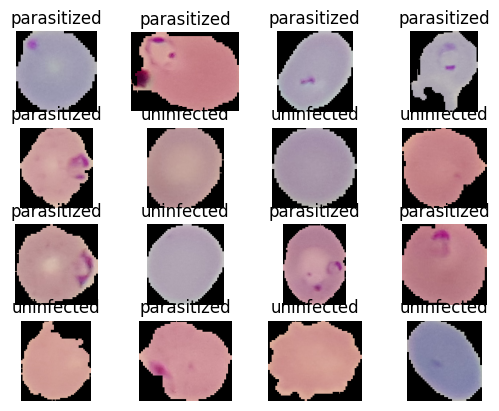

In [10]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# IMAGE PROCESSING

In [15]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [63]:
original_image, label = next(iter(train_dataset))

In [64]:
augmented_image = tf.image.flip_left_right(original_image)

In [69]:
augmented_image2 = tf.image.random_flip_up_down(original_image)

In [71]:
augmented_image3 = tf.image.rot90(original_image)

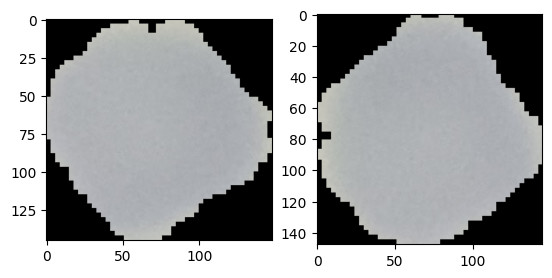

In [72]:
visualize(original_image, augmented_image3)

In [49]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# Data Processing

In [39]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [47]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [13]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


# Model creation

In [17]:
model = tf.keras.Sequential([
                            InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                            Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Flatten(),

                            Dense(1000, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(100, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Functional API

In [18]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64    

In [19]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name="feature_extractor")
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [20]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_10 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 100)               100100

# Model Subclassing

In [21]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

# Metrics

In [22]:
metrics = [BinaryAccuracy(name="accuracy"), TruePositives(name='tp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           FalsePositives(name='fp'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

# CallBacks

In [23]:
# Callback
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [24]:
# CSVLogger
csvlogger = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [25]:
# EarlyStopping
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [26]:
# Learning rate schedular
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrSchedular = LearningRateScheduler(scheduler, verbose=1)

In [27]:
# Model checkpointing
checkPoint = ModelCheckpoint(
    'checkpoint/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq=3,
)

In [28]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics)

# Training

In [29]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1,
                    callbacks=[csvlogger, earlystopping, lrSchedular, checkPoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
  2/689 [..............................] - ETA: 40s - loss: 2.5869 - accuracy: 0.5625 - tp: 20.0000 - tn: 16.0000 - fn: 13.0000 - fp: 15.0000 - precision: 0.5714 - recall: 0.6061 - auc: 0.5117  

  5/689 [..............................] - ETA: 50s - loss: 1.9515 - accuracy: 0.5938 - tp: 54.0000 - tn: 41.0000 - fn: 29.0000 - fp: 36.0000 - precision: 0.6000 - recall: 0.6506 - auc: 0.5829

  8/689 [..............................] - ETA: 55s - loss: 1.5785 - accuracy: 0.5859 - tp: 90.0000 - tn: 60.0000 - fn: 48.0000 - fp: 58.0000 - precision: 0.6081 - recall: 0.6522 - auc: 0.5638

 11/689 [..............................] - ETA: 55s - loss: 1.3587 - accuracy: 0.5483 - tp: 105.0000 - tn: 88.0000 - fn: 82.0000 - fp: 77.0000 - precision: 0.5769 - recall: 0.5615 - auc: 0.5535

 14/689 [..............................] - ETA: 55s - loss: 1.2229 - accuracy: 0.5469 - tp: 137.0000 - tn: 108.0000 - fn: 104.0000 - fp: 99.0000 - precision: 0.5805 - recall: 0.5685 - auc: 0.5548

 17/689 [..............................] - ETA: 54s - loss: 1.1326 - accuracy: 0.5478 - tp: 176.0000 - tn: 122.0000 - fn: 111.0000 - fp: 135.0000 - precision: 0.5659 - recall: 0.6132 - auc: 0.5564

 20/689 [..............................] - ETA: 54s - loss: 1.0700 - accuracy: 0.5422 - tp: 209.0000 - tn: 138.0000 - fn: 117.0000 - fp: 176.0000 - precision: 0.5429 - recall: 0.6411 - auc: 0.5579

 23/689 [>.............................] - ETA: 53s - loss: 1.0169 - accuracy: 0.5543 - tp: 251.0000 - tn: 157.0000 - fn: 128.0000 - fp: 200.0000 - precision: 0.5565 - recall: 0.6623 - auc: 0.5684

 26/689 [>.............................] - ETA: 53s - loss: 0.9739 - accuracy: 0.5649 - tp: 287.0000 - tn: 183.0000 - fn: 138.0000 - fp: 224.0000 - precision: 0.5616 - recall: 0.6753 - auc: 0.5767

 29/689 [>.............................] - ETA: 53s - loss: 0.9498 - accuracy: 0.5668 - tp: 318.0000 - tn: 208.0000 - fn: 155.0000 - fp: 247.0000 - precision: 0.5628 - recall: 0.6723 - auc: 0.5784

 32/689 [>.............................] - ETA: 52s - loss: 0.9227 - accuracy: 0.5732 - tp: 353.0000 - tn: 234.0000 - fn: 168.0000 - fp: 269.0000 - precision: 0.5675 - recall: 0.6775 - auc: 0.5841

 35/689 [>.............................] - ETA: 52s - loss: 0.9068 - accuracy: 0.5679 - tp: 385.0000 - tn: 251.0000 - fn: 188.0000 - fp: 296.0000 - precision: 0.5653 - recall: 0.6719 - auc: 0.5772

 38/689 [>.............................] - ETA: 52s - loss: 0.8866 - accuracy: 0.5748 - tp: 431.0000 - tn: 268.0000 - fn: 204.0000 - fp: 313.0000 - precision: 0.5793 - recall: 0.6787 - auc: 0.5797

 41/689 [>.............................] - ETA: 52s - loss: 0.8688 - accuracy: 0.5808 - tp: 473.0000 - tn: 289.0000 - fn: 212.0000 - fp: 338.0000 - precision: 0.5832 - recall: 0.6905 - auc: 0.5835

 44/689 [>.............................] - ETA: 51s - loss: 0.8544 - accuracy: 0.5824 - tp: 512.0000 - tn: 308.0000 - fn: 224.0000 - fp: 364.0000 - precision: 0.5845 - recall: 0.6957 - auc: 0.5866

 47/689 [=>............................] - ETA: 51s - loss: 0.8440 - accuracy: 0.5811 - tp: 550.0000 - tn: 324.0000 - fn: 234.0000 - fp: 396.0000 - precision: 0.5814 - recall: 0.7015 - auc: 0.5847

 50/689 [=>............................] - ETA: 51s - loss: 0.8350 - accuracy: 0.5825 - tp: 593.0000 - tn: 339.0000 - fn: 243.0000 - fp: 425.0000 - precision: 0.5825 - recall: 0.7093 - auc: 0.5886

 53/689 [=>............................] - ETA: 51s - loss: 0.8282 - accuracy: 0.5837 - tp: 633.0000 - tn: 357.0000 - fn: 254.0000 - fp: 452.0000 - precision: 0.5834 - recall: 0.7136 - auc: 0.5902

 56/689 [=>............................] - ETA: 51s - loss: 0.8202 - accuracy: 0.5843 - tp: 670.0000 - tn: 377.0000 - fn: 266.0000 - fp: 479.0000 - precision: 0.5831 - recall: 0.7158 - auc: 0.5917

 59/689 [=>............................] - ETA: 50s - loss: 0.8137 - accuracy: 0.5853 - tp: 706.0000 - tn: 399.0000 - fn: 274.0000 - fp: 509.0000 - precision: 0.5811 - recall: 0.7204 - auc: 0.5932

 62/689 [=>............................] - ETA: 49s - loss: 0.8068 - accuracy: 0.5852 - tp: 741.0000 - tn: 420.0000 - fn: 284.0000 - fp: 539.0000 - precision: 0.5789 - recall: 0.7229 - auc: 0.5948

 65/689 [=>............................] - ETA: 48s - loss: 0.8008 - accuracy: 0.5865 - tp: 777.0000 - tn: 443.0000 - fn: 302.0000 - fp: 558.0000 - precision: 0.5820 - recall: 0.7201 - auc: 0.5943

 68/689 [=>............................] - ETA: 48s - loss: 0.7928 - accuracy: 0.5915 - tp: 814.0000 - tn: 473.0000 - fn: 314.0000 - fp: 575.0000 - precision: 0.5860 - recall: 0.7216 - auc: 0.6003

 71/689 [==>...........................] - ETA: 48s - loss: 0.7890 - accuracy: 0.5907 - tp: 847.0000 - tn: 495.0000 - fn: 334.0000 - fp: 596.0000 - precision: 0.5870 - recall: 0.7172 - auc: 0.6017

 74/689 [==>...........................] - ETA: 48s - loss: 0.7862 - accuracy: 0.5929 - tp: 884.0000 - tn: 520.0000 - fn: 347.0000 - fp: 617.0000 - precision: 0.5889 - recall: 0.7181 - auc: 0.6027

 77/689 [==>...........................] - ETA: 48s - loss: 0.7826 - accuracy: 0.5954 - tp: 918.0000 - tn: 549.0000 - fn: 366.0000 - fp: 631.0000 - precision: 0.5926 - recall: 0.7150 - auc: 0.6052

 80/689 [==>...........................] - ETA: 48s - loss: 0.7822 - accuracy: 0.5945 - tp: 942.0000 - tn: 580.0000 - fn: 388.0000 - fp: 650.0000 - precision: 0.5917 - recall: 0.7083 - auc: 0.6027

 83/689 [==>...........................] - ETA: 48s - loss: 0.7780 - accuracy: 0.5956 - tp: 977.0000 - tn: 605.0000 - fn: 404.0000 - fp: 670.0000 - precision: 0.5932 - recall: 0.7075 - auc: 0.6027

 86/689 [==>...........................] - ETA: 47s - loss: 0.7773 - accuracy: 0.5930 - tp: 1010.0000 - tn: 622.0000 - fn: 417.0000 - fp: 703.0000 - precision: 0.5896 - recall: 0.7078 - auc: 0.5999

 89/689 [==>...........................] - ETA: 47s - loss: 0.7735 - accuracy: 0.5938 - tp: 1050.0000 - tn: 641.0000 - fn: 422.0000 - fp: 735.0000 - precision: 0.5882 - recall: 0.7133 - auc: 0.6034

 92/689 [===>..........................] - ETA: 47s - loss: 0.7682 - accuracy: 0.5954 - tp: 1085.0000 - tn: 668.0000 - fn: 429.0000 - fp: 762.0000 - precision: 0.5874 - recall: 0.7166 - auc: 0.6073

 95/689 [===>..........................] - ETA: 47s - loss: 0.7656 - accuracy: 0.5951 - tp: 1112.0000 - tn: 697.0000 - fn: 453.0000 - fp: 778.0000 - precision: 0.5884 - recall: 0.7105 - auc: 0.6076

 98/689 [===>..........................] - ETA: 46s - loss: 0.7632 - accuracy: 0.5960 - tp: 1130.0000 - tn: 739.0000 - fn: 473.0000 - fp: 794.0000 - precision: 0.5873 - recall: 0.7049 - auc: 0.6090

101/689 [===>..........................] - ETA: 47s - loss: 0.7610 - accuracy: 0.5938 - tp: 1152.0000 - tn: 767.0000 - fn: 502.0000 - fp: 811.0000 - precision: 0.5869 - recall: 0.6965 - auc: 0.6084

104/689 [===>..........................] - ETA: 46s - loss: 0.7586 - accuracy: 0.5938 - tp: 1174.0000 - tn: 802.0000 - fn: 519.0000 - fp: 833.0000 - precision: 0.5850 - recall: 0.6934 - auc: 0.6092

107/689 [===>..........................] - ETA: 46s - loss: 0.7552 - accuracy: 0.5952 - tp: 1214.0000 - tn: 824.0000 - fn: 529.0000 - fp: 857.0000 - precision: 0.5862 - recall: 0.6965 - auc: 0.6109

110/689 [===>..........................] - ETA: 46s - loss: 0.7559 - accuracy: 0.5952 - tp: 1249.0000 - tn: 846.0000 - fn: 541.0000 - fp: 884.0000 - precision: 0.5856 - recall: 0.6978 - auc: 0.6110

113/689 [===>..........................] - ETA: 46s - loss: 0.7524 - accuracy: 0.5979 - tp: 1281.0000 - tn: 881.0000 - fn: 552.0000 - fp: 902.0000 - precision: 0.5868 - recall: 0.6989 - auc: 0.6150

116/689 [====>.........................] - ETA: 45s - loss: 0.7497 - accuracy: 0.5991 - tp: 1314.0000 - tn: 910.0000 - fn: 571.0000 - fp: 917.0000 - precision: 0.5890 - recall: 0.6971 - auc: 0.6162

119/689 [====>.........................] - ETA: 45s - loss: 0.7467 - accuracy: 0.6001 - tp: 1342.0000 - tn: 943.0000 - fn: 586.0000 - fp: 937.0000 - precision: 0.5889 - recall: 0.6961 - auc: 0.6185

122/689 [====>.........................] - ETA: 45s - loss: 0.7449 - accuracy: 0.5996 - tp: 1364.0000 - tn: 977.0000 - fn: 608.0000 - fp: 955.0000 - precision: 0.5882 - recall: 0.6917 - auc: 0.6193

125/689 [====>.........................] - ETA: 45s - loss: 0.7440 - accuracy: 0.5993 - tp: 1384.0000 - tn: 1013.0000 - fn: 628.0000 - fp: 975.0000 - precision: 0.5867 - recall: 0.6879 - auc: 0.6189

128/689 [====>.........................] - ETA: 44s - loss: 0.7420 - accuracy: 0.5991 - tp: 1410.0000 - tn: 1044.0000 - fn: 649.0000 - fp: 993.0000 - precision: 0.5868 - recall: 0.6848 - auc: 0.6193

131/689 [====>.........................] - ETA: 44s - loss: 0.7410 - accuracy: 0.6002 - tp: 1446.0000 - tn: 1070.0000 - fn: 665.0000 - fp: 1011.0000 - precision: 0.5885 - recall: 0.6850 - auc: 0.6199

134/689 [====>.........................] - ETA: 44s - loss: 0.7393 - accuracy: 0.5989 - tp: 1480.0000 - tn: 1088.0000 - fn: 673.0000 - fp: 1047.0000 - precision: 0.5857 - recall: 0.6874 - auc: 0.6201

137/689 [====>.........................] - ETA: 44s - loss: 0.7405 - accuracy: 0.5979 - tp: 1519.0000 - tn: 1102.0000 - fn: 692.0000 - fp: 1071.0000 - precision: 0.5865 - recall: 0.6870 - auc: 0.6170

140/689 [=====>........................] - ETA: 44s - loss: 0.7397 - accuracy: 0.5964 - tp: 1547.0000 - tn: 1125.0000 - fn: 711.0000 - fp: 1097.0000 - precision: 0.5851 - recall: 0.6851 - auc: 0.6161

143/689 [=====>........................] - ETA: 43s - loss: 0.7386 - accuracy: 0.5955 - tp: 1572.0000 - tn: 1153.0000 - fn: 731.0000 - fp: 1120.0000 - precision: 0.5840 - recall: 0.6826 - auc: 0.6158

146/689 [=====>........................] - ETA: 43s - loss: 0.7371 - accuracy: 0.5963 - tp: 1605.0000 - tn: 1181.0000 - fn: 746.0000 - fp: 1140.0000 - precision: 0.5847 - recall: 0.6827 - auc: 0.6164

149/689 [=====>........................] - ETA: 43s - loss: 0.7360 - accuracy: 0.5971 - tp: 1640.0000 - tn: 1207.0000 - fn: 764.0000 - fp: 1157.0000 - precision: 0.5863 - recall: 0.6822 - auc: 0.6177

152/689 [=====>........................] - ETA: 43s - loss: 0.7360 - accuracy: 0.5960 - tp: 1669.0000 - tn: 1230.0000 - fn: 786.0000 - fp: 1179.0000 - precision: 0.5860 - recall: 0.6798 - auc: 0.6164

155/689 [=====>........................] - ETA: 43s - loss: 0.7353 - accuracy: 0.5954 - tp: 1699.0000 - tn: 1254.0000 - fn: 800.0000 - fp: 1207.0000 - precision: 0.5847 - recall: 0.6799 - auc: 0.6156

158/689 [=====>........................] - ETA: 42s - loss: 0.7347 - accuracy: 0.5936 - tp: 1731.0000 - tn: 1270.0000 - fn: 814.0000 - fp: 1241.0000 - precision: 0.5824 - recall: 0.6802 - auc: 0.6145

161/689 [======>.......................] - ETA: 42s - loss: 0.7334 - accuracy: 0.5932 - tp: 1767.0000 - tn: 1289.0000 - fn: 829.0000 - fp: 1267.0000 - precision: 0.5824 - recall: 0.6807 - auc: 0.6145

164/689 [======>.......................] - ETA: 42s - loss: 0.7323 - accuracy: 0.5939 - tp: 1808.0000 - tn: 1309.0000 - fn: 843.0000 - fp: 1288.0000 - precision: 0.5840 - recall: 0.6820 - auc: 0.6157

167/689 [======>.......................] - ETA: 42s - loss: 0.7338 - accuracy: 0.5934 - tp: 1841.0000 - tn: 1330.0000 - fn: 853.0000 - fp: 1320.0000 - precision: 0.5824 - recall: 0.6834 - auc: 0.6151

170/689 [======>.......................] - ETA: 42s - loss: 0.7328 - accuracy: 0.5943 - tp: 1871.0000 - tn: 1362.0000 - fn: 868.0000 - fp: 1339.0000 - precision: 0.5829 - recall: 0.6831 - auc: 0.6163

173/689 [======>.......................] - ETA: 41s - loss: 0.7317 - accuracy: 0.5939 - tp: 1895.0000 - tn: 1393.0000 - fn: 896.0000 - fp: 1352.0000 - precision: 0.5836 - recall: 0.6790 - auc: 0.6163

176/689 [======>.......................] - ETA: 41s - loss: 0.7310 - accuracy: 0.5938 - tp: 1916.0000 - tn: 1428.0000 - fn: 919.0000 - fp: 1369.0000 - precision: 0.5833 - recall: 0.6758 - auc: 0.6161

179/689 [======>.......................] - ETA: 41s - loss: 0.7299 - accuracy: 0.5944 - tp: 1939.0000 - tn: 1466.0000 - fn: 935.0000 - fp: 1388.0000 - precision: 0.5828 - recall: 0.6747 - auc: 0.6166

182/689 [======>.......................] - ETA: 40s - loss: 0.7288 - accuracy: 0.5944 - tp: 1969.0000 - tn: 1493.0000 - fn: 955.0000 - fp: 1407.0000 - precision: 0.5832 - recall: 0.6734 - auc: 0.6173

185/689 [=======>......................] - ETA: 40s - loss: 0.7274 - accuracy: 0.5951 - tp: 1998.0000 - tn: 1525.0000 - fn: 973.0000 - fp: 1424.0000 - precision: 0.5839 - recall: 0.6725 - auc: 0.6184

188/689 [=======>......................] - ETA: 40s - loss: 0.7266 - accuracy: 0.5946 - tp: 2028.0000 - tn: 1549.0000 - fn: 997.0000 - fp: 1442.0000 - precision: 0.5844 - recall: 0.6704 - auc: 0.6180

191/689 [=======>......................] - ETA: 40s - loss: 0.7255 - accuracy: 0.5952 - tp: 2065.0000 - tn: 1573.0000 - fn: 1014.0000 - fp: 1460.0000 - precision: 0.5858 - recall: 0.6707 - auc: 0.6184

194/689 [=======>......................] - ETA: 39s - loss: 0.7241 - accuracy: 0.5958 - tp: 2102.0000 - tn: 1597.0000 - fn: 1026.0000 - fp: 1483.0000 - precision: 0.5863 - recall: 0.6720 - auc: 0.6190

197/689 [=======>......................] - ETA: 39s - loss: 0.7244 - accuracy: 0.5945 - tp: 2138.0000 - tn: 1610.0000 - fn: 1043.0000 - fp: 1513.0000 - precision: 0.5856 - recall: 0.6721 - auc: 0.6173

200/689 [=======>......................] - ETA: 39s - loss: 0.7236 - accuracy: 0.5942 - tp: 2176.0000 - tn: 1627.0000 - fn: 1053.0000 - fp: 1544.0000 - precision: 0.5849 - recall: 0.6739 - auc: 0.6173

203/689 [=======>......................] - ETA: 39s - loss: 0.7226 - accuracy: 0.5948 - tp: 2214.0000 - tn: 1650.0000 - fn: 1064.0000 - fp: 1568.0000 - precision: 0.5854 - recall: 0.6754 - auc: 0.6176

206/689 [=======>......................] - ETA: 38s - loss: 0.7222 - accuracy: 0.5945 - tp: 2249.0000 - tn: 1670.0000 - fn: 1079.0000 - fp: 1594.0000 - precision: 0.5852 - recall: 0.6758 - auc: 0.6171

209/689 [========>.....................] - ETA: 38s - loss: 0.7220 - accuracy: 0.5938 - tp: 2278.0000 - tn: 1693.0000 - fn: 1092.0000 - fp: 1625.0000 - precision: 0.5837 - recall: 0.6760 - auc: 0.6162

212/689 [========>.....................] - ETA: 38s - loss: 0.7207 - accuracy: 0.5955 - tp: 2310.0000 - tn: 1730.0000 - fn: 1101.0000 - fp: 1643.0000 - precision: 0.5844 - recall: 0.6772 - auc: 0.6177

215/689 [========>.....................] - ETA: 38s - loss: 0.7197 - accuracy: 0.5961 - tp: 2338.0000 - tn: 1763.0000 - fn: 1112.0000 - fp: 1667.0000 - precision: 0.5838 - recall: 0.6777 - auc: 0.6181

217/689 [========>.....................] - ETA: 38s - loss: 0.7190 - accuracy: 0.5962 - tp: 2357.0000 - tn: 1783.0000 - fn: 1123.0000 - fp: 1681.0000 - precision: 0.5837 - recall: 0.6773 - auc: 0.6186

221/689 [========>.....................] - ETA: 37s - loss: 0.7180 - accuracy: 0.5966 - tp: 2403.0000 - tn: 1816.0000 - fn: 1150.0000 - fp: 1703.0000 - precision: 0.5852 - recall: 0.6763 - auc: 0.6188

224/689 [========>.....................] - ETA: 37s - loss: 0.7175 - accuracy: 0.5965 - tp: 2439.0000 - tn: 1837.0000 - fn: 1163.0000 - fp: 1729.0000 - precision: 0.5852 - recall: 0.6771 - auc: 0.6186

227/689 [========>.....................] - ETA: 37s - loss: 0.7166 - accuracy: 0.5971 - tp: 2477.0000 - tn: 1860.0000 - fn: 1173.0000 - fp: 1754.0000 - precision: 0.5854 - recall: 0.6786 - auc: 0.6191

229/689 [========>.....................] - ETA: 36s - loss: 0.7160 - accuracy: 0.5968 - tp: 2497.0000 - tn: 1876.0000 - fn: 1178.0000 - fp: 1777.0000 - precision: 0.5842 - recall: 0.6795 - auc: 0.6195

233/689 [=========>....................] - ETA: 36s - loss: 0.7151 - accuracy: 0.5974 - tp: 2543.0000 - tn: 1911.0000 - fn: 1191.0000 - fp: 1811.0000 - precision: 0.5841 - recall: 0.6810 - auc: 0.6198

236/689 [=========>....................] - ETA: 36s - loss: 0.7146 - accuracy: 0.5977 - tp: 2577.0000 - tn: 1937.0000 - fn: 1212.0000 - fp: 1826.0000 - precision: 0.5853 - recall: 0.6801 - auc: 0.6200

239/689 [=========>....................] - ETA: 35s - loss: 0.7134 - accuracy: 0.5983 - tp: 2603.0000 - tn: 1973.0000 - fn: 1230.0000 - fp: 1842.0000 - precision: 0.5856 - recall: 0.6791 - auc: 0.6213

242/689 [=========>....................] - ETA: 35s - loss: 0.7122 - accuracy: 0.6001 - tp: 2638.0000 - tn: 2009.0000 - fn: 1245.0000 - fp: 1852.0000 - precision: 0.5875 - recall: 0.6794 - auc: 0.6229

245/689 [=========>....................] - ETA: 35s - loss: 0.7124 - accuracy: 0.5995 - tp: 2664.0000 - tn: 2036.0000 - fn: 1272.0000 - fp: 1868.0000 - precision: 0.5878 - recall: 0.6768 - auc: 0.6223

248/689 [=========>....................] - ETA: 35s - loss: 0.7113 - accuracy: 0.5998 - tp: 2694.0000 - tn: 2066.0000 - fn: 1287.0000 - fp: 1889.0000 - precision: 0.5878 - recall: 0.6767 - auc: 0.6234

251/689 [=========>....................] - ETA: 34s - loss: 0.7102 - accuracy: 0.6001 - tp: 2729.0000 - tn: 2091.0000 - fn: 1302.0000 - fp: 1910.0000 - precision: 0.5883 - recall: 0.6770 - auc: 0.6245

254/689 [==========>...................] - ETA: 34s - loss: 0.7100 - accuracy: 0.5995 - tp: 2761.0000 - tn: 2112.0000 - fn: 1312.0000 - fp: 1943.0000 - precision: 0.5869 - recall: 0.6779 - auc: 0.6243

257/689 [==========>...................] - ETA: 34s - loss: 0.7092 - accuracy: 0.5995 - tp: 2800.0000 - tn: 2130.0000 - fn: 1322.0000 - fp: 1972.0000 - precision: 0.5868 - recall: 0.6793 - auc: 0.6244

260/689 [==========>...................] - ETA: 34s - loss: 0.7083 - accuracy: 0.6004 - tp: 2840.0000 - tn: 2155.0000 - fn: 1333.0000 - fp: 1992.0000 - precision: 0.5877 - recall: 0.6806 - auc: 0.6250

263/689 [==========>...................] - ETA: 33s - loss: 0.7079 - accuracy: 0.6003 - tp: 2874.0000 - tn: 2178.0000 - fn: 1342.0000 - fp: 2022.0000 - precision: 0.5870 - recall: 0.6817 - auc: 0.6252

266/689 [==========>...................] - ETA: 33s - loss: 0.7066 - accuracy: 0.6016 - tp: 2912.0000 - tn: 2209.0000 - fn: 1350.0000 - fp: 2041.0000 - precision: 0.5879 - recall: 0.6832 - auc: 0.6268

269/689 [==========>...................] - ETA: 33s - loss: 0.7062 - accuracy: 0.6020 - tp: 2947.0000 - tn: 2235.0000 - fn: 1366.0000 - fp: 2060.0000 - precision: 0.5886 - recall: 0.6833 - auc: 0.6278

272/689 [==========>...................] - ETA: 33s - loss: 0.7059 - accuracy: 0.6023 - tp: 2982.0000 - tn: 2260.0000 - fn: 1386.0000 - fp: 2076.0000 - precision: 0.5896 - recall: 0.6827 - auc: 0.6282

275/689 [==========>...................] - ETA: 33s - loss: 0.7055 - accuracy: 0.6020 - tp: 3005.0000 - tn: 2293.0000 - fn: 1406.0000 - fp: 2096.0000 - precision: 0.5891 - recall: 0.6813 - auc: 0.6281

278/689 [===========>..................] - ETA: 32s - loss: 0.7048 - accuracy: 0.6021 - tp: 3031.0000 - tn: 2325.0000 - fn: 1426.0000 - fp: 2114.0000 - precision: 0.5891 - recall: 0.6801 - auc: 0.6285

281/689 [===========>..................] - ETA: 32s - loss: 0.7041 - accuracy: 0.6023 - tp: 3065.0000 - tn: 2351.0000 - fn: 1442.0000 - fp: 2134.0000 - precision: 0.5895 - recall: 0.6801 - auc: 0.6289

284/689 [===========>..................] - ETA: 32s - loss: 0.7040 - accuracy: 0.6021 - tp: 3098.0000 - tn: 2374.0000 - fn: 1458.0000 - fp: 2158.0000 - precision: 0.5894 - recall: 0.6800 - auc: 0.6286

287/689 [===========>..................] - ETA: 32s - loss: 0.7039 - accuracy: 0.6016 - tp: 3128.0000 - tn: 2397.0000 - fn: 1474.0000 - fp: 2185.0000 - precision: 0.5887 - recall: 0.6797 - auc: 0.6281

290/689 [===========>..................] - ETA: 31s - loss: 0.7030 - accuracy: 0.6027 - tp: 3164.0000 - tn: 2429.0000 - fn: 1480.0000 - fp: 2207.0000 - precision: 0.5891 - recall: 0.6813 - auc: 0.6291

293/689 [===========>..................] - ETA: 31s - loss: 0.7022 - accuracy: 0.6030 - tp: 3194.0000 - tn: 2460.0000 - fn: 1499.0000 - fp: 2223.0000 - precision: 0.5896 - recall: 0.6806 - auc: 0.6299

296/689 [===========>..................] - ETA: 31s - loss: 0.7019 - accuracy: 0.6033 - tp: 3227.0000 - tn: 2487.0000 - fn: 1515.0000 - fp: 2243.0000 - precision: 0.5899 - recall: 0.6805 - auc: 0.6301

299/689 [============>.................] - ETA: 30s - loss: 0.7017 - accuracy: 0.6029 - tp: 3255.0000 - tn: 2514.0000 - fn: 1534.0000 - fp: 2265.0000 - precision: 0.5897 - recall: 0.6797 - auc: 0.6301

302/689 [============>.................] - ETA: 30s - loss: 0.7013 - accuracy: 0.6031 - tp: 3293.0000 - tn: 2535.0000 - fn: 1549.0000 - fp: 2287.0000 - precision: 0.5901 - recall: 0.6801 - auc: 0.6302

305/689 [============>.................] - ETA: 30s - loss: 0.7012 - accuracy: 0.6025 - tp: 3325.0000 - tn: 2555.0000 - fn: 1562.0000 - fp: 2318.0000 - precision: 0.5892 - recall: 0.6804 - auc: 0.6300

308/689 [============>.................] - ETA: 30s - loss: 0.7009 - accuracy: 0.6014 - tp: 3344.0000 - tn: 2583.0000 - fn: 1584.0000 - fp: 2345.0000 - precision: 0.5878 - recall: 0.6786 - auc: 0.6300

311/689 [============>.................] - ETA: 29s - loss: 0.7007 - accuracy: 0.6012 - tp: 3374.0000 - tn: 2609.0000 - fn: 1604.0000 - fp: 2365.0000 - precision: 0.5879 - recall: 0.6778 - auc: 0.6298

314/689 [============>.................] - ETA: 29s - loss: 0.7000 - accuracy: 0.6017 - tp: 3412.0000 - tn: 2634.0000 - fn: 1619.0000 - fp: 2383.0000 - precision: 0.5888 - recall: 0.6782 - auc: 0.6306

317/689 [============>.................] - ETA: 29s - loss: 0.6993 - accuracy: 0.6022 - tp: 3448.0000 - tn: 2661.0000 - fn: 1628.0000 - fp: 2407.0000 - precision: 0.5889 - recall: 0.6793 - auc: 0.6315

320/689 [============>.................] - ETA: 29s - loss: 0.6988 - accuracy: 0.6026 - tp: 3485.0000 - tn: 2686.0000 - fn: 1644.0000 - fp: 2425.0000 - precision: 0.5897 - recall: 0.6795 - auc: 0.6317

323/689 [=============>................] - ETA: 28s - loss: 0.6987 - accuracy: 0.6027 - tp: 3520.0000 - tn: 2710.0000 - fn: 1655.0000 - fp: 2451.0000 - precision: 0.5895 - recall: 0.6802 - auc: 0.6315

326/689 [=============>................] - ETA: 28s - loss: 0.6983 - accuracy: 0.6026 - tp: 3553.0000 - tn: 2733.0000 - fn: 1670.0000 - fp: 2476.0000 - precision: 0.5893 - recall: 0.6803 - auc: 0.6314

329/689 [=============>................] - ETA: 28s - loss: 0.6982 - accuracy: 0.6021 - tp: 3582.0000 - tn: 2757.0000 - fn: 1680.0000 - fp: 2509.0000 - precision: 0.5881 - recall: 0.6807 - auc: 0.6313

332/689 [=============>................] - ETA: 28s - loss: 0.6982 - accuracy: 0.6013 - tp: 3605.0000 - tn: 2783.0000 - fn: 1701.0000 - fp: 2535.0000 - precision: 0.5871 - recall: 0.6794 - auc: 0.6308

335/689 [=============>................] - ETA: 27s - loss: 0.6981 - accuracy: 0.6007 - tp: 3631.0000 - tn: 2809.0000 - fn: 1731.0000 - fp: 2549.0000 - precision: 0.5875 - recall: 0.6772 - auc: 0.6304

338/689 [=============>................] - ETA: 27s - loss: 0.6977 - accuracy: 0.6010 - tp: 3655.0000 - tn: 2845.0000 - fn: 1749.0000 - fp: 2567.0000 - precision: 0.5874 - recall: 0.6764 - auc: 0.6306

341/689 [=============>................] - ETA: 27s - loss: 0.6973 - accuracy: 0.6014 - tp: 3692.0000 - tn: 2871.0000 - fn: 1764.0000 - fp: 2585.0000 - precision: 0.5882 - recall: 0.6767 - auc: 0.6309

344/689 [=============>................] - ETA: 27s - loss: 0.6972 - accuracy: 0.6015 - tp: 3724.0000 - tn: 2897.0000 - fn: 1778.0000 - fp: 2609.0000 - precision: 0.5880 - recall: 0.6768 - auc: 0.6309

347/689 [==============>...............] - ETA: 27s - loss: 0.6969 - accuracy: 0.6014 - tp: 3756.0000 - tn: 2922.0000 - fn: 1787.0000 - fp: 2639.0000 - precision: 0.5873 - recall: 0.6776 - auc: 0.6309

350/689 [==============>...............] - ETA: 26s - loss: 0.6966 - accuracy: 0.6016 - tp: 3787.0000 - tn: 2951.0000 - fn: 1794.0000 - fp: 2668.0000 - precision: 0.5867 - recall: 0.6786 - auc: 0.6309

353/689 [==============>...............] - ETA: 26s - loss: 0.6964 - accuracy: 0.6022 - tp: 3828.0000 - tn: 2975.0000 - fn: 1807.0000 - fp: 2686.0000 - precision: 0.5877 - recall: 0.6793 - auc: 0.6306

356/689 [==============>...............] - ETA: 26s - loss: 0.6958 - accuracy: 0.6029 - tp: 3868.0000 - tn: 3000.0000 - fn: 1815.0000 - fp: 2709.0000 - precision: 0.5881 - recall: 0.6806 - auc: 0.6310

359/689 [==============>...............] - ETA: 26s - loss: 0.6956 - accuracy: 0.6032 - tp: 3910.0000 - tn: 3020.0000 - fn: 1827.0000 - fp: 2731.0000 - precision: 0.5888 - recall: 0.6815 - auc: 0.6313

362/689 [==============>...............] - ETA: 25s - loss: 0.6950 - accuracy: 0.6040 - tp: 3951.0000 - tn: 3046.0000 - fn: 1839.0000 - fp: 2748.0000 - precision: 0.5898 - recall: 0.6824 - auc: 0.6324

365/689 [==============>...............] - ETA: 25s - loss: 0.6950 - accuracy: 0.6038 - tp: 3986.0000 - tn: 3066.0000 - fn: 1849.0000 - fp: 2779.0000 - precision: 0.5892 - recall: 0.6831 - auc: 0.6320

368/689 [===============>..............] - ETA: 25s - loss: 0.6950 - accuracy: 0.6031 - tp: 4017.0000 - tn: 3085.0000 - fn: 1862.0000 - fp: 2812.0000 - precision: 0.5882 - recall: 0.6833 - auc: 0.6315

371/689 [===============>..............] - ETA: 25s - loss: 0.6950 - accuracy: 0.6024 - tp: 4044.0000 - tn: 3108.0000 - fn: 1888.0000 - fp: 2832.0000 - precision: 0.5881 - recall: 0.6817 - auc: 0.6309

374/689 [===============>..............] - ETA: 25s - loss: 0.6948 - accuracy: 0.6023 - tp: 4067.0000 - tn: 3141.0000 - fn: 1907.0000 - fp: 2853.0000 - precision: 0.5877 - recall: 0.6808 - auc: 0.6310

377/689 [===============>..............] - ETA: 24s - loss: 0.6946 - accuracy: 0.6021 - tp: 4101.0000 - tn: 3163.0000 - fn: 1925.0000 - fp: 2875.0000 - precision: 0.5879 - recall: 0.6806 - auc: 0.6310

380/689 [===============>..............] - ETA: 24s - loss: 0.6948 - accuracy: 0.6021 - tp: 4136.0000 - tn: 3185.0000 - fn: 1940.0000 - fp: 2899.0000 - precision: 0.5879 - recall: 0.6807 - auc: 0.6306

383/689 [===============>..............] - ETA: 24s - loss: 0.6943 - accuracy: 0.6027 - tp: 4172.0000 - tn: 3215.0000 - fn: 1948.0000 - fp: 2921.0000 - precision: 0.5882 - recall: 0.6817 - auc: 0.6309

386/689 [===============>..............] - ETA: 24s - loss: 0.6938 - accuracy: 0.6034 - tp: 4206.0000 - tn: 3247.0000 - fn: 1959.0000 - fp: 2940.0000 - precision: 0.5886 - recall: 0.6822 - auc: 0.6315

389/689 [===============>..............] - ETA: 23s - loss: 0.6931 - accuracy: 0.6040 - tp: 4240.0000 - tn: 3278.0000 - fn: 1970.0000 - fp: 2960.0000 - precision: 0.5889 - recall: 0.6828 - auc: 0.6323

392/689 [================>.............] - ETA: 23s - loss: 0.6925 - accuracy: 0.6046 - tp: 4281.0000 - tn: 3303.0000 - fn: 1981.0000 - fp: 2979.0000 - precision: 0.5897 - recall: 0.6836 - auc: 0.6331

395/689 [================>.............] - ETA: 23s - loss: 0.6928 - accuracy: 0.6044 - tp: 4319.0000 - tn: 3321.0000 - fn: 1998.0000 - fp: 3002.0000 - precision: 0.5899 - recall: 0.6837 - auc: 0.6328

398/689 [================>.............] - ETA: 23s - loss: 0.6924 - accuracy: 0.6044 - tp: 4352.0000 - tn: 3346.0000 - fn: 2015.0000 - fp: 3023.0000 - precision: 0.5901 - recall: 0.6835 - auc: 0.6329

401/689 [================>.............] - ETA: 22s - loss: 0.6921 - accuracy: 0.6044 - tp: 4384.0000 - tn: 3372.0000 - fn: 2029.0000 - fp: 3047.0000 - precision: 0.5900 - recall: 0.6836 - auc: 0.6331

404/689 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.6036 - tp: 4411.0000 - tn: 3392.0000 - fn: 2052.0000 - fp: 3073.0000 - precision: 0.5894 - recall: 0.6825 - auc: 0.6325

407/689 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.6028 - tp: 4439.0000 - tn: 3412.0000 - fn: 2073.0000 - fp: 3100.0000 - precision: 0.5888 - recall: 0.6817 - auc: 0.6320

410/689 [================>.............] - ETA: 22s - loss: 0.6921 - accuracy: 0.6024 - tp: 4466.0000 - tn: 3438.0000 - fn: 2092.0000 - fp: 3124.0000 - precision: 0.5884 - recall: 0.6810 - auc: 0.6320

413/689 [================>.............] - ETA: 21s - loss: 0.6922 - accuracy: 0.6021 - tp: 4492.0000 - tn: 3465.0000 - fn: 2109.0000 - fp: 3150.0000 - precision: 0.5878 - recall: 0.6805 - auc: 0.6315

416/689 [=================>............] - ETA: 21s - loss: 0.6916 - accuracy: 0.6029 - tp: 4531.0000 - tn: 3495.0000 - fn: 2119.0000 - fp: 3167.0000 - precision: 0.5886 - recall: 0.6814 - auc: 0.6321

419/689 [=================>............] - ETA: 21s - loss: 0.6907 - accuracy: 0.6037 - tp: 4571.0000 - tn: 3523.0000 - fn: 2128.0000 - fp: 3186.0000 - precision: 0.5893 - recall: 0.6823 - auc: 0.6332

422/689 [=================>............] - ETA: 21s - loss: 0.6905 - accuracy: 0.6040 - tp: 4608.0000 - tn: 3548.0000 - fn: 2139.0000 - fp: 3209.0000 - precision: 0.5895 - recall: 0.6830 - auc: 0.6338

425/689 [=================>............] - ETA: 20s - loss: 0.6899 - accuracy: 0.6046 - tp: 4647.0000 - tn: 3576.0000 - fn: 2152.0000 - fp: 3225.0000 - precision: 0.5903 - recall: 0.6835 - auc: 0.6347

428/689 [=================>............] - ETA: 20s - loss: 0.6896 - accuracy: 0.6048 - tp: 4685.0000 - tn: 3598.0000 - fn: 2163.0000 - fp: 3250.0000 - precision: 0.5904 - recall: 0.6841 - auc: 0.6349

431/689 [=================>............] - ETA: 20s - loss: 0.6895 - accuracy: 0.6047 - tp: 4722.0000 - tn: 3618.0000 - fn: 2180.0000 - fp: 3272.0000 - precision: 0.5907 - recall: 0.6841 - auc: 0.6349

434/689 [=================>............] - ETA: 20s - loss: 0.6892 - accuracy: 0.6048 - tp: 4760.0000 - tn: 3639.0000 - fn: 2193.0000 - fp: 3296.0000 - precision: 0.5909 - recall: 0.6846 - auc: 0.6351

437/689 [==================>...........] - ETA: 19s - loss: 0.6890 - accuracy: 0.6049 - tp: 4790.0000 - tn: 3669.0000 - fn: 2211.0000 - fp: 3314.0000 - precision: 0.5911 - recall: 0.6842 - auc: 0.6352

440/689 [==================>...........] - ETA: 19s - loss: 0.6886 - accuracy: 0.6052 - tp: 4822.0000 - tn: 3699.0000 - fn: 2223.0000 - fp: 3336.0000 - precision: 0.5911 - recall: 0.6845 - auc: 0.6357

443/689 [==================>...........] - ETA: 19s - loss: 0.6892 - accuracy: 0.6044 - tp: 4849.0000 - tn: 3719.0000 - fn: 2242.0000 - fp: 3366.0000 - precision: 0.5903 - recall: 0.6838 - auc: 0.6346

446/689 [==================>...........] - ETA: 19s - loss: 0.6895 - accuracy: 0.6043 - tp: 4882.0000 - tn: 3742.0000 - fn: 2255.0000 - fp: 3393.0000 - precision: 0.5900 - recall: 0.6840 - auc: 0.6341

449/689 [==================>...........] - ETA: 18s - loss: 0.6893 - accuracy: 0.6048 - tp: 4920.0000 - tn: 3770.0000 - fn: 2268.0000 - fp: 3410.0000 - precision: 0.5906 - recall: 0.6845 - auc: 0.6342

452/689 [==================>...........] - ETA: 18s - loss: 0.6893 - accuracy: 0.6044 - tp: 4947.0000 - tn: 3795.0000 - fn: 2285.0000 - fp: 3437.0000 - precision: 0.5901 - recall: 0.6840 - auc: 0.6340

455/689 [==================>...........] - ETA: 18s - loss: 0.6893 - accuracy: 0.6041 - tp: 4980.0000 - tn: 3816.0000 - fn: 2308.0000 - fp: 3456.0000 - precision: 0.5903 - recall: 0.6833 - auc: 0.6336

458/689 [==================>...........] - ETA: 18s - loss: 0.6890 - accuracy: 0.6043 - tp: 5015.0000 - tn: 3841.0000 - fn: 2325.0000 - fp: 3475.0000 - precision: 0.5907 - recall: 0.6832 - auc: 0.6338

461/689 [===================>..........] - ETA: 18s - loss: 0.6887 - accuracy: 0.6045 - tp: 5042.0000 - tn: 3875.0000 - fn: 2335.0000 - fp: 3500.0000 - precision: 0.5903 - recall: 0.6835 - auc: 0.6341

464/689 [===================>..........] - ETA: 17s - loss: 0.6883 - accuracy: 0.6051 - tp: 5076.0000 - tn: 3908.0000 - fn: 2348.0000 - fp: 3516.0000 - precision: 0.5908 - recall: 0.6837 - auc: 0.6345

467/689 [===================>..........] - ETA: 17s - loss: 0.6880 - accuracy: 0.6053 - tp: 5110.0000 - tn: 3935.0000 - fn: 2369.0000 - fp: 3530.0000 - precision: 0.5914 - recall: 0.6832 - auc: 0.6349

470/689 [===================>..........] - ETA: 17s - loss: 0.6879 - accuracy: 0.6054 - tp: 5136.0000 - tn: 3969.0000 - fn: 2384.0000 - fp: 3551.0000 - precision: 0.5912 - recall: 0.6830 - auc: 0.6350

473/689 [===================>..........] - ETA: 17s - loss: 0.6872 - accuracy: 0.6060 - tp: 5168.0000 - tn: 4005.0000 - fn: 2400.0000 - fp: 3563.0000 - precision: 0.5919 - recall: 0.6829 - auc: 0.6360

476/689 [===================>..........] - ETA: 16s - loss: 0.6869 - accuracy: 0.6063 - tp: 5201.0000 - tn: 4034.0000 - fn: 2412.0000 - fp: 3585.0000 - precision: 0.5920 - recall: 0.6832 - auc: 0.6364

479/689 [===================>..........] - ETA: 16s - loss: 0.6867 - accuracy: 0.6065 - tp: 5239.0000 - tn: 4057.0000 - fn: 2426.0000 - fp: 3606.0000 - precision: 0.5923 - recall: 0.6835 - auc: 0.6369

482/689 [===================>..........] - ETA: 16s - loss: 0.6861 - accuracy: 0.6067 - tp: 5269.0000 - tn: 4089.0000 - fn: 2439.0000 - fp: 3627.0000 - precision: 0.5923 - recall: 0.6836 - auc: 0.6374

485/689 [====================>.........] - ETA: 16s - loss: 0.6854 - accuracy: 0.6074 - tp: 5305.0000 - tn: 4122.0000 - fn: 2451.0000 - fp: 3642.0000 - precision: 0.5929 - recall: 0.6840 - auc: 0.6385

488/689 [====================>.........] - ETA: 15s - loss: 0.6850 - accuracy: 0.6076 - tp: 5340.0000 - tn: 4149.0000 - fn: 2467.0000 - fp: 3660.0000 - precision: 0.5933 - recall: 0.6840 - auc: 0.6391

491/689 [====================>.........] - ETA: 15s - loss: 0.6846 - accuracy: 0.6081 - tp: 5376.0000 - tn: 4179.0000 - fn: 2486.0000 - fp: 3671.0000 - precision: 0.5942 - recall: 0.6838 - auc: 0.6397

494/689 [====================>.........] - ETA: 15s - loss: 0.6842 - accuracy: 0.6084 - tp: 5402.0000 - tn: 4215.0000 - fn: 2506.0000 - fp: 3685.0000 - precision: 0.5945 - recall: 0.6831 - auc: 0.6402

497/689 [====================>.........] - ETA: 15s - loss: 0.6842 - accuracy: 0.6081 - tp: 5420.0000 - tn: 4252.0000 - fn: 2527.0000 - fp: 3705.0000 - precision: 0.5940 - recall: 0.6820 - auc: 0.6401

500/689 [====================>.........] - ETA: 14s - loss: 0.6840 - accuracy: 0.6081 - tp: 5447.0000 - tn: 4282.0000 - fn: 2553.0000 - fp: 3718.0000 - precision: 0.5943 - recall: 0.6809 - auc: 0.6402

503/689 [====================>.........] - ETA: 14s - loss: 0.6837 - accuracy: 0.6083 - tp: 5483.0000 - tn: 4309.0000 - fn: 2567.0000 - fp: 3737.0000 - precision: 0.5947 - recall: 0.6811 - auc: 0.6406

506/689 [=====================>........] - ETA: 14s - loss: 0.6834 - accuracy: 0.6086 - tp: 5522.0000 - tn: 4332.0000 - fn: 2579.0000 - fp: 3759.0000 - precision: 0.5950 - recall: 0.6816 - auc: 0.6407

509/689 [=====================>........] - ETA: 14s - loss: 0.6833 - accuracy: 0.6087 - tp: 5563.0000 - tn: 4352.0000 - fn: 2590.0000 - fp: 3783.0000 - precision: 0.5952 - recall: 0.6823 - auc: 0.6408

512/689 [=====================>........] - ETA: 14s - loss: 0.6830 - accuracy: 0.6088 - tp: 5603.0000 - tn: 4371.0000 - fn: 2596.0000 - fp: 3814.0000 - precision: 0.5950 - recall: 0.6834 - auc: 0.6411

515/689 [=====================>........] - ETA: 13s - loss: 0.6828 - accuracy: 0.6089 - tp: 5640.0000 - tn: 4395.0000 - fn: 2600.0000 - fp: 3845.0000 - precision: 0.5946 - recall: 0.6845 - auc: 0.6413

518/689 [=====================>........] - ETA: 13s - loss: 0.6823 - accuracy: 0.6091 - tp: 5671.0000 - tn: 4426.0000 - fn: 2606.0000 - fp: 3873.0000 - precision: 0.5942 - recall: 0.6852 - auc: 0.6420

521/689 [=====================>........] - ETA: 13s - loss: 0.6822 - accuracy: 0.6092 - tp: 5707.0000 - tn: 4450.0000 - fn: 2620.0000 - fp: 3895.0000 - precision: 0.5944 - recall: 0.6854 - auc: 0.6420

524/689 [=====================>........] - ETA: 13s - loss: 0.6819 - accuracy: 0.6092 - tp: 5734.0000 - tn: 4481.0000 - fn: 2634.0000 - fp: 3919.0000 - precision: 0.5940 - recall: 0.6852 - auc: 0.6423

527/689 [=====================>........] - ETA: 12s - loss: 0.6817 - accuracy: 0.6095 - tp: 5765.0000 - tn: 4514.0000 - fn: 2652.0000 - fp: 3933.0000 - precision: 0.5945 - recall: 0.6849 - auc: 0.6424

530/689 [======================>.......] - ETA: 12s - loss: 0.6813 - accuracy: 0.6098 - tp: 5791.0000 - tn: 4551.0000 - fn: 2667.0000 - fp: 3951.0000 - precision: 0.5944 - recall: 0.6847 - auc: 0.6431

533/689 [======================>.......] - ETA: 12s - loss: 0.6811 - accuracy: 0.6098 - tp: 5824.0000 - tn: 4576.0000 - fn: 2690.0000 - fp: 3966.0000 - precision: 0.5949 - recall: 0.6840 - auc: 0.6430

536/689 [======================>.......] - ETA: 12s - loss: 0.6811 - accuracy: 0.6097 - tp: 5851.0000 - tn: 4607.0000 - fn: 2707.0000 - fp: 3987.0000 - precision: 0.5947 - recall: 0.6837 - auc: 0.6430

539/689 [======================>.......] - ETA: 11s - loss: 0.6810 - accuracy: 0.6098 - tp: 5875.0000 - tn: 4642.0000 - fn: 2733.0000 - fp: 3998.0000 - precision: 0.5951 - recall: 0.6825 - auc: 0.6431

542/689 [======================>.......] - ETA: 11s - loss: 0.6809 - accuracy: 0.6100 - tp: 5906.0000 - tn: 4673.0000 - fn: 2754.0000 - fp: 4011.0000 - precision: 0.5955 - recall: 0.6820 - auc: 0.6431

545/689 [======================>.......] - ETA: 11s - loss: 0.6807 - accuracy: 0.6102 - tp: 5938.0000 - tn: 4704.0000 - fn: 2768.0000 - fp: 4030.0000 - precision: 0.5957 - recall: 0.6821 - auc: 0.6433

548/689 [======================>.......] - ETA: 11s - loss: 0.6805 - accuracy: 0.6107 - tp: 5977.0000 - tn: 4732.0000 - fn: 2783.0000 - fp: 4044.0000 - precision: 0.5964 - recall: 0.6823 - auc: 0.6435

551/689 [======================>.......] - ETA: 10s - loss: 0.6803 - accuracy: 0.6108 - tp: 6011.0000 - tn: 4758.0000 - fn: 2799.0000 - fp: 4064.0000 - precision: 0.5966 - recall: 0.6823 - auc: 0.6436

554/689 [=======================>......] - ETA: 10s - loss: 0.6801 - accuracy: 0.6110 - tp: 6048.0000 - tn: 4783.0000 - fn: 2814.0000 - fp: 4083.0000 - precision: 0.5970 - recall: 0.6825 - auc: 0.6439

557/689 [=======================>......] - ETA: 10s - loss: 0.6802 - accuracy: 0.6109 - tp: 6081.0000 - tn: 4807.0000 - fn: 2826.0000 - fp: 4110.0000 - precision: 0.5967 - recall: 0.6827 - auc: 0.6437

560/689 [=======================>......] - ETA: 10s - loss: 0.6804 - accuracy: 0.6104 - tp: 6107.0000 - tn: 4831.0000 - fn: 2841.0000 - fp: 4141.0000 - precision: 0.5959 - recall: 0.6825 - auc: 0.6433

563/689 [=======================>......] - ETA: 9s - loss: 0.6806 - accuracy: 0.6098 - tp: 6134.0000 - tn: 4853.0000 - fn: 2857.0000 - fp: 4172.0000 - precision: 0.5952 - recall: 0.6822 - auc: 0.6430 

566/689 [=======================>......] - ETA: 9s - loss: 0.6807 - accuracy: 0.6094 - tp: 6152.0000 - tn: 4885.0000 - fn: 2882.0000 - fp: 4193.0000 - precision: 0.5947 - recall: 0.6810 - auc: 0.6425

569/689 [=======================>......] - ETA: 9s - loss: 0.6809 - accuracy: 0.6088 - tp: 6173.0000 - tn: 4912.0000 - fn: 2916.0000 - fp: 4207.0000 - precision: 0.5947 - recall: 0.6792 - auc: 0.6420

572/689 [=======================>......] - ETA: 9s - loss: 0.6806 - accuracy: 0.6089 - tp: 6208.0000 - tn: 4937.0000 - fn: 2931.0000 - fp: 4228.0000 - precision: 0.5949 - recall: 0.6793 - auc: 0.6423

575/689 [========================>.....] - ETA: 9s - loss: 0.6804 - accuracy: 0.6092 - tp: 6249.0000 - tn: 4961.0000 - fn: 2938.0000 - fp: 4252.0000 - precision: 0.5951 - recall: 0.6802 - auc: 0.6425

578/689 [========================>.....] - ETA: 8s - loss: 0.6803 - accuracy: 0.6092 - tp: 6283.0000 - tn: 4985.0000 - fn: 2946.0000 - fp: 4282.0000 - precision: 0.5947 - recall: 0.6808 - auc: 0.6428

581/689 [========================>.....] - ETA: 8s - loss: 0.6802 - accuracy: 0.6093 - tp: 6326.0000 - tn: 5003.0000 - fn: 2957.0000 - fp: 4306.0000 - precision: 0.5950 - recall: 0.6815 - auc: 0.6429

584/689 [========================>.....] - ETA: 8s - loss: 0.6800 - accuracy: 0.6095 - tp: 6360.0000 - tn: 5030.0000 - fn: 2977.0000 - fp: 4321.0000 - precision: 0.5954 - recall: 0.6812 - auc: 0.6431

587/689 [========================>.....] - ETA: 8s - loss: 0.6800 - accuracy: 0.6090 - tp: 6385.0000 - tn: 5055.0000 - fn: 3003.0000 - fp: 4341.0000 - precision: 0.5953 - recall: 0.6801 - auc: 0.6428

590/689 [========================>.....] - ETA: 7s - loss: 0.6801 - accuracy: 0.6088 - tp: 6412.0000 - tn: 5082.0000 - fn: 3029.0000 - fp: 4357.0000 - precision: 0.5954 - recall: 0.6792 - auc: 0.6424

593/689 [========================>.....] - ETA: 7s - loss: 0.6803 - accuracy: 0.6080 - tp: 6432.0000 - tn: 5105.0000 - fn: 3057.0000 - fp: 4382.0000 - precision: 0.5948 - recall: 0.6778 - auc: 0.6420

596/689 [========================>.....] - ETA: 7s - loss: 0.6803 - accuracy: 0.6080 - tp: 6458.0000 - tn: 5137.0000 - fn: 3073.0000 - fp: 4404.0000 - precision: 0.5945 - recall: 0.6776 - auc: 0.6418

599/689 [=========================>....] - ETA: 7s - loss: 0.6802 - accuracy: 0.6081 - tp: 6487.0000 - tn: 5169.0000 - fn: 3089.0000 - fp: 4423.0000 - precision: 0.5946 - recall: 0.6774 - auc: 0.6418

602/689 [=========================>....] - ETA: 6s - loss: 0.6800 - accuracy: 0.6083 - tp: 6519.0000 - tn: 5200.0000 - fn: 3103.0000 - fp: 4442.0000 - precision: 0.5947 - recall: 0.6775 - auc: 0.6422

605/689 [=========================>....] - ETA: 6s - loss: 0.6797 - accuracy: 0.6087 - tp: 6558.0000 - tn: 5227.0000 - fn: 3116.0000 - fp: 4459.0000 - precision: 0.5953 - recall: 0.6779 - auc: 0.6428

608/689 [=========================>....] - ETA: 6s - loss: 0.6802 - accuracy: 0.6087 - tp: 6594.0000 - tn: 5248.0000 - fn: 3135.0000 - fp: 4479.0000 - precision: 0.5955 - recall: 0.6778 - auc: 0.6424

611/689 [=========================>....] - ETA: 6s - loss: 0.6800 - accuracy: 0.6086 - tp: 6624.0000 - tn: 5276.0000 - fn: 3152.0000 - fp: 4500.0000 - precision: 0.5955 - recall: 0.6776 - auc: 0.6425

614/689 [=========================>....] - ETA: 5s - loss: 0.6798 - accuracy: 0.6088 - tp: 6651.0000 - tn: 5310.0000 - fn: 3173.0000 - fp: 4514.0000 - precision: 0.5957 - recall: 0.6770 - auc: 0.6426

617/689 [=========================>....] - ETA: 5s - loss: 0.6798 - accuracy: 0.6086 - tp: 6680.0000 - tn: 5337.0000 - fn: 3198.0000 - fp: 4529.0000 - precision: 0.5959 - recall: 0.6763 - auc: 0.6425

620/689 [=========================>....] - ETA: 5s - loss: 0.6799 - accuracy: 0.6082 - tp: 6709.0000 - tn: 5358.0000 - fn: 3222.0000 - fp: 4551.0000 - precision: 0.5958 - recall: 0.6756 - auc: 0.6421

623/689 [==========================>...] - ETA: 5s - loss: 0.6795 - accuracy: 0.6089 - tp: 6751.0000 - tn: 5388.0000 - fn: 3232.0000 - fp: 4565.0000 - precision: 0.5966 - recall: 0.6762 - auc: 0.6427

626/689 [==========================>...] - ETA: 4s - loss: 0.6792 - accuracy: 0.6092 - tp: 6792.0000 - tn: 5411.0000 - fn: 3237.0000 - fp: 4592.0000 - precision: 0.5966 - recall: 0.6772 - auc: 0.6430

629/689 [==========================>...] - ETA: 4s - loss: 0.6792 - accuracy: 0.6093 - tp: 6830.0000 - tn: 5433.0000 - fn: 3252.0000 - fp: 4613.0000 - precision: 0.5969 - recall: 0.6774 - auc: 0.6431

632/689 [==========================>...] - ETA: 4s - loss: 0.6792 - accuracy: 0.6092 - tp: 6871.0000 - tn: 5450.0000 - fn: 3268.0000 - fp: 4635.0000 - precision: 0.5972 - recall: 0.6777 - auc: 0.6430

635/689 [==========================>...] - ETA: 4s - loss: 0.6790 - accuracy: 0.6093 - tp: 6910.0000 - tn: 5471.0000 - fn: 3281.0000 - fp: 4658.0000 - precision: 0.5973 - recall: 0.6780 - auc: 0.6433

638/689 [==========================>...] - ETA: 4s - loss: 0.6786 - accuracy: 0.6100 - tp: 6951.0000 - tn: 5502.0000 - fn: 3293.0000 - fp: 4670.0000 - precision: 0.5981 - recall: 0.6785 - auc: 0.6440

641/689 [==========================>...] - ETA: 3s - loss: 0.6786 - accuracy: 0.6098 - tp: 6982.0000 - tn: 5526.0000 - fn: 3305.0000 - fp: 4699.0000 - precision: 0.5977 - recall: 0.6787 - auc: 0.6438

644/689 [===========================>..] - ETA: 3s - loss: 0.6785 - accuracy: 0.6097 - tp: 7014.0000 - tn: 5551.0000 - fn: 3319.0000 - fp: 4724.0000 - precision: 0.5975 - recall: 0.6788 - auc: 0.6440

647/689 [===========================>..] - ETA: 3s - loss: 0.6786 - accuracy: 0.6094 - tp: 7044.0000 - tn: 5573.0000 - fn: 3340.0000 - fp: 4747.0000 - precision: 0.5974 - recall: 0.6784 - auc: 0.6436

650/689 [===========================>..] - ETA: 3s - loss: 0.6783 - accuracy: 0.6100 - tp: 7083.0000 - tn: 5604.0000 - fn: 3346.0000 - fp: 4767.0000 - precision: 0.5977 - recall: 0.6792 - auc: 0.6438

653/689 [===========================>..] - ETA: 2s - loss: 0.6783 - accuracy: 0.6101 - tp: 7121.0000 - tn: 5628.0000 - fn: 3355.0000 - fp: 4792.0000 - precision: 0.5978 - recall: 0.6797 - auc: 0.6439

656/689 [===========================>..] - ETA: 2s - loss: 0.6782 - accuracy: 0.6102 - tp: 7157.0000 - tn: 5652.0000 - fn: 3361.0000 - fp: 4822.0000 - precision: 0.5975 - recall: 0.6805 - auc: 0.6440

658/689 [===========================>..] - ETA: 2s - loss: 0.6781 - accuracy: 0.6103 - tp: 7185.0000 - tn: 5665.0000 - fn: 3367.0000 - fp: 4839.0000 - precision: 0.5976 - recall: 0.6809 - auc: 0.6440

662/689 [===========================>..] - ETA: 2s - loss: 0.6778 - accuracy: 0.6105 - tp: 7224.0000 - tn: 5709.0000 - fn: 3379.0000 - fp: 4872.0000 - precision: 0.5972 - recall: 0.6813 - auc: 0.6445

665/689 [===========================>..] - ETA: 1s - loss: 0.6777 - accuracy: 0.6108 - tp: 7253.0000 - tn: 5745.0000 - fn: 3396.0000 - fp: 4886.0000 - precision: 0.5975 - recall: 0.6811 - auc: 0.6447

668/689 [============================>.] - ETA: 1s - loss: 0.6773 - accuracy: 0.6115 - tp: 7287.0000 - tn: 5784.0000 - fn: 3412.0000 - fp: 4893.0000 - precision: 0.5983 - recall: 0.6811 - auc: 0.6452

670/689 [============================>.] - ETA: 1s - loss: 0.6773 - accuracy: 0.6115 - tp: 7302.0000 - tn: 5809.0000 - fn: 3426.0000 - fp: 4903.0000 - precision: 0.5983 - recall: 0.6806 - auc: 0.6452

673/689 [============================>.] - ETA: 1s - loss: 0.6772 - accuracy: 0.6117 - tp: 7325.0000 - tn: 5848.0000 - fn: 3447.0000 - fp: 4916.0000 - precision: 0.5984 - recall: 0.6800 - auc: 0.6454

677/689 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6116 - tp: 7357.0000 - tn: 5892.0000 - fn: 3479.0000 - fp: 4936.0000 - precision: 0.5985 - recall: 0.6789 - auc: 0.6455

680/689 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6115 - tp: 7389.0000 - tn: 5917.0000 - fn: 3497.0000 - fp: 4957.0000 - precision: 0.5985 - recall: 0.6788 - auc: 0.6454

683/689 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6114 - tp: 7417.0000 - tn: 5945.0000 - fn: 3518.0000 - fp: 4976.0000 - precision: 0.5985 - recall: 0.6783 - auc: 0.6453

686/689 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6115 - tp: 7446.0000 - tn: 5977.0000 - fn: 3534.0000 - fp: 4995.0000 - precision: 0.5985 - recall: 0.6781 - auc: 0.6452

689/689 [==============================] - 88s 97ms/step - loss: 0.6768 - accuracy: 0.6118 - tp: 7476.0000 - tn: 6011.0000 - fn: 3546.0000 - fp: 5013.0000 - precision: 0.5986 - recall: 0.6783 - auc: 0.6456 - val_loss: 0.6601 - val_accuracy: 0.6076 - val_tp: 717.0000 - val_tn: 957.0000 - val_fn: 671.0000 - val_fp: 410.0000 - val_precision: 0.6362 - val_recall: 0.5166 - val_auc: 0.6603 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10


  2/689 [..............................] - ETA: 37s - loss: 0.6553 - accuracy: 0.6250 - tp: 20.0000 - tn: 20.0000 - fn: 13.0000 - fp: 11.0000 - precision: 0.6452 - recall: 0.6061 - auc: 0.6481

  6/689 [..............................] - ETA: 32s - loss: 0.6406 - accuracy: 0.6406 - tp: 68.0000 - tn: 55.0000 - fn: 35.0000 - fp: 34.0000 - precision: 0.6667 - recall: 0.6602 - auc: 0.6888

  9/689 [..............................] - ETA: 32s - loss: 0.6503 - accuracy: 0.6424 - tp: 103.0000 - tn: 82.0000 - fn: 49.0000 - fp: 54.0000 - precision: 0.6561 - recall: 0.6776 - auc: 0.6774

 11/689 [..............................] - ETA: 32s - loss: 0.6413 - accuracy: 0.6506 - tp: 126.0000 - tn: 103.0000 - fn: 57.0000 - fp: 66.0000 - precision: 0.6562 - recall: 0.6885 - auc: 0.6904

 15/689 [..............................] - ETA: 31s - loss: 0.6431 - accuracy: 0.6375 - tp: 170.0000 - tn: 136.0000 - fn: 86.0000 - fp: 88.0000 - precision: 0.6589 - recall: 0.6641 - auc: 0.6854

 17/689 [..............................] - ETA: 31s - loss: 0.6426 - accuracy: 0.6324 - tp: 185.0000 - tn: 159.0000 - fn: 94.0000 - fp: 106.0000 - precision: 0.6357 - recall: 0.6631 - auc: 0.6829

 21/689 [..............................] - ETA: 31s - loss: 0.6349 - accuracy: 0.6295 - tp: 230.0000 - tn: 193.0000 - fn: 113.0000 - fp: 136.0000 - precision: 0.6284 - recall: 0.6706 - auc: 0.6921

 24/689 [>.............................] - ETA: 30s - loss: 0.6369 - accuracy: 0.6328 - tp: 272.0000 - tn: 214.0000 - fn: 121.0000 - fp: 161.0000 - precision: 0.6282 - recall: 0.6921 - auc: 0.6904

 26/689 [>.............................] - ETA: 30s - loss: 0.6376 - accuracy: 0.6298 - tp: 294.0000 - tn: 230.0000 - fn: 128.0000 - fp: 180.0000 - precision: 0.6203 - recall: 0.6967 - auc: 0.6878

 30/689 [>.............................] - ETA: 31s - loss: 0.6434 - accuracy: 0.6250 - tp: 344.0000 - tn: 256.0000 - fn: 143.0000 - fp: 217.0000 - precision: 0.6132 - recall: 0.7064 - auc: 0.6789

 33/689 [>.............................] - ETA: 33s - loss: 0.6422 - accuracy: 0.6326 - tp: 389.0000 - tn: 279.0000 - fn: 151.0000 - fp: 237.0000 - precision: 0.6214 - recall: 0.7204 - auc: 0.6799

 36/689 [>.............................] - ETA: 34s - loss: 0.6460 - accuracy: 0.6215 - tp: 419.0000 - tn: 297.0000 - fn: 175.0000 - fp: 261.0000 - precision: 0.6162 - recall: 0.7054 - auc: 0.6713

 39/689 [>.............................] - ETA: 35s - loss: 0.6435 - accuracy: 0.6314 - tp: 469.0000 - tn: 319.0000 - fn: 184.0000 - fp: 276.0000 - precision: 0.6295 - recall: 0.7182 - auc: 0.6749

 42/689 [>.............................] - ETA: 35s - loss: 0.6444 - accuracy: 0.6332 - tp: 508.0000 - tn: 343.0000 - fn: 198.0000 - fp: 295.0000 - precision: 0.6326 - recall: 0.7195 - auc: 0.6749

 45/689 [>.............................] - ETA: 36s - loss: 0.6452 - accuracy: 0.6326 - tp: 542.0000 - tn: 369.0000 - fn: 214.0000 - fp: 315.0000 - precision: 0.6324 - recall: 0.7169 - auc: 0.6732

 48/689 [=>............................] - ETA: 37s - loss: 0.6446 - accuracy: 0.6315 - tp: 570.0000 - tn: 400.0000 - fn: 227.0000 - fp: 339.0000 - precision: 0.6271 - recall: 0.7152 - auc: 0.6742

 51/689 [=>............................] - ETA: 37s - loss: 0.6445 - accuracy: 0.6317 - tp: 608.0000 - tn: 423.0000 - fn: 245.0000 - fp: 356.0000 - precision: 0.6307 - recall: 0.7128 - auc: 0.6743

 54/689 [=>............................] - ETA: 38s - loss: 0.6438 - accuracy: 0.6325 - tp: 643.0000 - tn: 450.0000 - fn: 259.0000 - fp: 376.0000 - precision: 0.6310 - recall: 0.7129 - auc: 0.6762

 57/689 [=>............................] - ETA: 38s - loss: 0.6461 - accuracy: 0.6305 - tp: 679.0000 - tn: 471.0000 - fn: 271.0000 - fp: 403.0000 - precision: 0.6275 - recall: 0.7147 - auc: 0.6720

 60/689 [=>............................] - ETA: 39s - loss: 0.6454 - accuracy: 0.6313 - tp: 713.0000 - tn: 499.0000 - fn: 278.0000 - fp: 430.0000 - precision: 0.6238 - recall: 0.7195 - auc: 0.6734

 63/689 [=>............................] - ETA: 39s - loss: 0.6474 - accuracy: 0.6300 - tp: 747.0000 - tn: 523.0000 - fn: 293.0000 - fp: 453.0000 - precision: 0.6225 - recall: 0.7183 - auc: 0.6702

 65/689 [=>............................] - ETA: 40s - loss: 0.6469 - accuracy: 0.6313 - tp: 771.0000 - tn: 542.0000 - fn: 308.0000 - fp: 459.0000 - precision: 0.6268 - recall: 0.7146 - auc: 0.6707

 69/689 [==>...........................] - ETA: 40s - loss: 0.6467 - accuracy: 0.6327 - tp: 815.0000 - tn: 582.0000 - fn: 331.0000 - fp: 480.0000 - precision: 0.6293 - recall: 0.7112 - auc: 0.6714

 72/689 [==>...........................] - ETA: 39s - loss: 0.6475 - accuracy: 0.6302 - tp: 844.0000 - tn: 608.0000 - fn: 353.0000 - fp: 499.0000 - precision: 0.6284 - recall: 0.7051 - auc: 0.6700

 75/689 [==>...........................] - ETA: 39s - loss: 0.6476 - accuracy: 0.6321 - tp: 878.0000 - tn: 639.0000 - fn: 370.0000 - fp: 513.0000 - precision: 0.6312 - recall: 0.7035 - auc: 0.6698

 78/689 [==>...........................] - ETA: 40s - loss: 0.6481 - accuracy: 0.6306 - tp: 908.0000 - tn: 666.0000 - fn: 386.0000 - fp: 536.0000 - precision: 0.6288 - recall: 0.7017 - auc: 0.6695

 81/689 [==>...........................] - ETA: 39s - loss: 0.6505 - accuracy: 0.6262 - tp: 934.0000 - tn: 689.0000 - fn: 414.0000 - fp: 555.0000 - precision: 0.6273 - recall: 0.6929 - auc: 0.6648

 84/689 [==>...........................] - ETA: 40s - loss: 0.6516 - accuracy: 0.6265 - tp: 973.0000 - tn: 711.0000 - fn: 428.0000 - fp: 576.0000 - precision: 0.6281 - recall: 0.6945 - auc: 0.6624

 86/689 [==>...........................] - ETA: 39s - loss: 0.6531 - accuracy: 0.6217 - tp: 994.0000 - tn: 717.0000 - fn: 433.0000 - fp: 608.0000 - precision: 0.6205 - recall: 0.6966 - auc: 0.6602

 90/689 [==>...........................] - ETA: 39s - loss: 0.6540 - accuracy: 0.6201 - tp: 1037.0000 - tn: 749.0000 - fn: 452.0000 - fp: 642.0000 - precision: 0.6176 - recall: 0.6964 - auc: 0.6586

 93/689 [===>..........................] - ETA: 38s - loss: 0.6536 - accuracy: 0.6210 - tp: 1067.0000 - tn: 781.0000 - fn: 465.0000 - fp: 663.0000 - precision: 0.6168 - recall: 0.6965 - auc: 0.6593

 96/689 [===>..........................] - ETA: 38s - loss: 0.6537 - accuracy: 0.6221 - tp: 1100.0000 - tn: 811.0000 - fn: 477.0000 - fp: 684.0000 - precision: 0.6166 - recall: 0.6975 - auc: 0.6597

 98/689 [===>..........................] - ETA: 37s - loss: 0.6547 - accuracy: 0.6221 - tp: 1118.0000 - tn: 833.0000 - fn: 485.0000 - fp: 700.0000 - precision: 0.6150 - recall: 0.6974 - auc: 0.6586

102/689 [===>..........................] - ETA: 37s - loss: 0.6556 - accuracy: 0.6222 - tp: 1164.0000 - tn: 867.0000 - fn: 505.0000 - fp: 728.0000 - precision: 0.6152 - recall: 0.6974 - auc: 0.6577

105/689 [===>..........................] - ETA: 36s - loss: 0.6555 - accuracy: 0.6217 - tp: 1196.0000 - tn: 893.0000 - fn: 516.0000 - fp: 755.0000 - precision: 0.6130 - recall: 0.6986 - auc: 0.6575

108/689 [===>..........................] - ETA: 36s - loss: 0.6551 - accuracy: 0.6230 - tp: 1221.0000 - tn: 932.0000 - fn: 536.0000 - fp: 767.0000 - precision: 0.6142 - recall: 0.6949 - auc: 0.6580

110/689 [===>..........................] - ETA: 36s - loss: 0.6558 - accuracy: 0.6227 - tp: 1244.0000 - tn: 948.0000 - fn: 545.0000 - fp: 783.0000 - precision: 0.6137 - recall: 0.6954 - auc: 0.6567

114/689 [===>..........................] - ETA: 35s - loss: 0.6554 - accuracy: 0.6236 - tp: 1288.0000 - tn: 987.0000 - fn: 564.0000 - fp: 809.0000 - precision: 0.6142 - recall: 0.6955 - auc: 0.6579

117/689 [====>.........................] - ETA: 35s - loss: 0.6549 - accuracy: 0.6250 - tp: 1322.0000 - tn: 1018.0000 - fn: 578.0000 - fp: 826.0000 - precision: 0.6155 - recall: 0.6958 - auc: 0.6588

120/689 [====>.........................] - ETA: 34s - loss: 0.6562 - accuracy: 0.6232 - tp: 1343.0000 - tn: 1050.0000 - fn: 598.0000 - fp: 849.0000 - precision: 0.6127 - recall: 0.6919 - auc: 0.6567

123/689 [====>.........................] - ETA: 34s - loss: 0.6565 - accuracy: 0.6225 - tp: 1368.0000 - tn: 1082.0000 - fn: 620.0000 - fp: 866.0000 - precision: 0.6124 - recall: 0.6881 - auc: 0.6561

125/689 [====>.........................] - ETA: 34s - loss: 0.6567 - accuracy: 0.6220 - tp: 1380.0000 - tn: 1108.0000 - fn: 635.0000 - fp: 877.0000 - precision: 0.6114 - recall: 0.6849 - auc: 0.6561

129/689 [====>.........................] - ETA: 33s - loss: 0.6576 - accuracy: 0.6194 - tp: 1397.0000 - tn: 1160.0000 - fn: 677.0000 - fp: 894.0000 - precision: 0.6098 - recall: 0.6736 - auc: 0.6543

131/689 [====>.........................] - ETA: 33s - loss: 0.6579 - accuracy: 0.6183 - tp: 1409.0000 - tn: 1183.0000 - fn: 701.0000 - fp: 899.0000 - precision: 0.6105 - recall: 0.6678 - auc: 0.6534

135/689 [====>.........................] - ETA: 32s - loss: 0.6580 - accuracy: 0.6183 - tp: 1446.0000 - tn: 1225.0000 - fn: 726.0000 - fp: 923.0000 - precision: 0.6104 - recall: 0.6657 - auc: 0.6532

138/689 [=====>........................] - ETA: 32s - loss: 0.6587 - accuracy: 0.6180 - tp: 1480.0000 - tn: 1249.0000 - fn: 747.0000 - fp: 940.0000 - precision: 0.6116 - recall: 0.6646 - auc: 0.6520

140/689 [=====>........................] - ETA: 32s - loss: 0.6602 - accuracy: 0.6161 - tp: 1496.0000 - tn: 1264.0000 - fn: 762.0000 - fp: 958.0000 - precision: 0.6096 - recall: 0.6625 - auc: 0.6494

144/689 [=====>........................] - ETA: 31s - loss: 0.6595 - accuracy: 0.6165 - tp: 1538.0000 - tn: 1303.0000 - fn: 783.0000 - fp: 984.0000 - precision: 0.6098 - recall: 0.6626 - auc: 0.6505

146/689 [=====>........................] - ETA: 31s - loss: 0.6593 - accuracy: 0.6171 - tp: 1560.0000 - tn: 1323.0000 - fn: 792.0000 - fp: 997.0000 - precision: 0.6101 - recall: 0.6633 - auc: 0.6508

149/689 [=====>........................] - ETA: 31s - loss: 0.6591 - accuracy: 0.6172 - tp: 1593.0000 - tn: 1350.0000 - fn: 809.0000 - fp: 1016.0000 - precision: 0.6106 - recall: 0.6632 - auc: 0.6510

153/689 [=====>........................] - ETA: 30s - loss: 0.6586 - accuracy: 0.6176 - tp: 1640.0000 - tn: 1384.0000 - fn: 829.0000 - fp: 1043.0000 - precision: 0.6113 - recall: 0.6642 - auc: 0.6516

156/689 [=====>........................] - ETA: 30s - loss: 0.6598 - accuracy: 0.6152 - tp: 1667.0000 - tn: 1404.0000 - fn: 850.0000 - fp: 1071.0000 - precision: 0.6088 - recall: 0.6623 - auc: 0.6490

159/689 [=====>........................] - ETA: 30s - loss: 0.6595 - accuracy: 0.6156 - tp: 1703.0000 - tn: 1429.0000 - fn: 859.0000 - fp: 1097.0000 - precision: 0.6082 - recall: 0.6647 - auc: 0.6496

161/689 [======>.......................] - ETA: 30s - loss: 0.6590 - accuracy: 0.6163 - tp: 1732.0000 - tn: 1443.0000 - fn: 863.0000 - fp: 1114.0000 - precision: 0.6086 - recall: 0.6674 - auc: 0.6505

165/689 [======>.......................] - ETA: 29s - loss: 0.6591 - accuracy: 0.6165 - tp: 1784.0000 - tn: 1471.0000 - fn: 880.0000 - fp: 1145.0000 - precision: 0.6091 - recall: 0.6697 - auc: 0.6500

168/689 [======>.......................] - ETA: 29s - loss: 0.6597 - accuracy: 0.6164 - tp: 1815.0000 - tn: 1499.0000 - fn: 890.0000 - fp: 1172.0000 - precision: 0.6076 - recall: 0.6710 - auc: 0.6490

171/689 [======>.......................] - ETA: 29s - loss: 0.6593 - accuracy: 0.6168 - tp: 1851.0000 - tn: 1524.0000 - fn: 905.0000 - fp: 1192.0000 - precision: 0.6083 - recall: 0.6716 - auc: 0.6498

174/689 [======>.......................] - ETA: 28s - loss: 0.6587 - accuracy: 0.6175 - tp: 1888.0000 - tn: 1550.0000 - fn: 916.0000 - fp: 1214.0000 - precision: 0.6086 - recall: 0.6733 - auc: 0.6503

177/689 [======>.......................] - ETA: 28s - loss: 0.6588 - accuracy: 0.6171 - tp: 1919.0000 - tn: 1576.0000 - fn: 929.0000 - fp: 1240.0000 - precision: 0.6075 - recall: 0.6738 - auc: 0.6500

180/689 [======>.......................] - ETA: 28s - loss: 0.6584 - accuracy: 0.6174 - tp: 1953.0000 - tn: 1603.0000 - fn: 943.0000 - fp: 1261.0000 - precision: 0.6077 - recall: 0.6744 - auc: 0.6507

182/689 [======>.......................] - ETA: 28s - loss: 0.6581 - accuracy: 0.6183 - tp: 1975.0000 - tn: 1626.0000 - fn: 950.0000 - fp: 1273.0000 - precision: 0.6081 - recall: 0.6752 - auc: 0.6513

186/689 [=======>......................] - ETA: 27s - loss: 0.6577 - accuracy: 0.6191 - tp: 2019.0000 - tn: 1666.0000 - fn: 968.0000 - fp: 1299.0000 - precision: 0.6085 - recall: 0.6759 - auc: 0.6521

189/689 [=======>......................] - ETA: 27s - loss: 0.6580 - accuracy: 0.6194 - tp: 2056.0000 - tn: 1690.0000 - fn: 986.0000 - fp: 1316.0000 - precision: 0.6097 - recall: 0.6759 - auc: 0.6519

192/689 [=======>......................] - ETA: 27s - loss: 0.6576 - accuracy: 0.6204 - tp: 2099.0000 - tn: 1713.0000 - fn: 999.0000 - fp: 1333.0000 - precision: 0.6116 - recall: 0.6775 - auc: 0.6527

195/689 [=======>......................] - ETA: 27s - loss: 0.6578 - accuracy: 0.6199 - tp: 2131.0000 - tn: 1737.0000 - fn: 1014.0000 - fp: 1358.0000 - precision: 0.6108 - recall: 0.6776 - auc: 0.6522

198/689 [=======>......................] - ETA: 27s - loss: 0.6581 - accuracy: 0.6193 - tp: 2169.0000 - tn: 1755.0000 - fn: 1028.0000 - fp: 1384.0000 - precision: 0.6105 - recall: 0.6784 - auc: 0.6515

201/689 [=======>......................] - ETA: 27s - loss: 0.6582 - accuracy: 0.6196 - tp: 2207.0000 - tn: 1778.0000 - fn: 1038.0000 - fp: 1409.0000 - precision: 0.6103 - recall: 0.6801 - auc: 0.6513

204/689 [=======>......................] - ETA: 26s - loss: 0.6581 - accuracy: 0.6198 - tp: 2251.0000 - tn: 1795.0000 - fn: 1049.0000 - fp: 1433.0000 - precision: 0.6110 - recall: 0.6821 - auc: 0.6514

207/689 [========>.....................] - ETA: 26s - loss: 0.6586 - accuracy: 0.6185 - tp: 2277.0000 - tn: 1820.0000 - fn: 1060.0000 - fp: 1467.0000 - precision: 0.6082 - recall: 0.6823 - auc: 0.6503

210/689 [========>.....................] - ETA: 26s - loss: 0.6582 - accuracy: 0.6195 - tp: 2315.0000 - tn: 1848.0000 - fn: 1068.0000 - fp: 1489.0000 - precision: 0.6086 - recall: 0.6843 - auc: 0.6510

213/689 [========>.....................] - ETA: 26s - loss: 0.6583 - accuracy: 0.6193 - tp: 2343.0000 - tn: 1878.0000 - fn: 1081.0000 - fp: 1514.0000 - precision: 0.6075 - recall: 0.6843 - auc: 0.6505

216/689 [========>.....................] - ETA: 26s - loss: 0.6580 - accuracy: 0.6192 - tp: 2376.0000 - tn: 1904.0000 - fn: 1094.0000 - fp: 1538.0000 - precision: 0.6071 - recall: 0.6847 - auc: 0.6509

219/689 [========>.....................] - ETA: 25s - loss: 0.6577 - accuracy: 0.6193 - tp: 2409.0000 - tn: 1931.0000 - fn: 1109.0000 - fp: 1559.0000 - precision: 0.6071 - recall: 0.6848 - auc: 0.6514

222/689 [========>.....................] - ETA: 25s - loss: 0.6580 - accuracy: 0.6184 - tp: 2440.0000 - tn: 1953.0000 - fn: 1130.0000 - fp: 1581.0000 - precision: 0.6068 - recall: 0.6835 - auc: 0.6507

224/689 [========>.....................] - ETA: 25s - loss: 0.6580 - accuracy: 0.6186 - tp: 2466.0000 - tn: 1968.0000 - fn: 1137.0000 - fp: 1597.0000 - precision: 0.6069 - recall: 0.6844 - auc: 0.6506

227/689 [========>.....................] - ETA: 25s - loss: 0.6576 - accuracy: 0.6198 - tp: 2504.0000 - tn: 1998.0000 - fn: 1144.0000 - fp: 1618.0000 - precision: 0.6075 - recall: 0.6864 - auc: 0.6513

231/689 [=========>....................] - ETA: 25s - loss: 0.6572 - accuracy: 0.6199 - tp: 2550.0000 - tn: 2032.0000 - fn: 1159.0000 - fp: 1651.0000 - precision: 0.6070 - recall: 0.6875 - auc: 0.6521

234/689 [=========>....................] - ETA: 24s - loss: 0.6575 - accuracy: 0.6195 - tp: 2580.0000 - tn: 2059.0000 - fn: 1172.0000 - fp: 1677.0000 - precision: 0.6061 - recall: 0.6876 - auc: 0.6516

237/689 [=========>....................] - ETA: 24s - loss: 0.6572 - accuracy: 0.6203 - tp: 2615.0000 - tn: 2089.0000 - fn: 1193.0000 - fp: 1687.0000 - precision: 0.6079 - recall: 0.6867 - auc: 0.6523

240/689 [=========>....................] - ETA: 24s - loss: 0.6569 - accuracy: 0.6208 - tp: 2640.0000 - tn: 2128.0000 - fn: 1210.0000 - fp: 1702.0000 - precision: 0.6080 - recall: 0.6857 - auc: 0.6527

242/689 [=========>....................] - ETA: 24s - loss: 0.6564 - accuracy: 0.6213 - tp: 2660.0000 - tn: 2151.0000 - fn: 1221.0000 - fp: 1712.0000 - precision: 0.6084 - recall: 0.6854 - auc: 0.6538

246/689 [=========>....................] - ETA: 23s - loss: 0.6560 - accuracy: 0.6216 - tp: 2705.0000 - tn: 2188.0000 - fn: 1247.0000 - fp: 1732.0000 - precision: 0.6096 - recall: 0.6845 - auc: 0.6544

249/689 [=========>....................] - ETA: 23s - loss: 0.6555 - accuracy: 0.6224 - tp: 2740.0000 - tn: 2219.0000 - fn: 1258.0000 - fp: 1751.0000 - precision: 0.6101 - recall: 0.6853 - auc: 0.6552

252/689 [=========>....................] - ETA: 23s - loss: 0.6555 - accuracy: 0.6219 - tp: 2771.0000 - tn: 2244.0000 - fn: 1277.0000 - fp: 1772.0000 - precision: 0.6099 - recall: 0.6845 - auc: 0.6554

254/689 [==========>...................] - ETA: 23s - loss: 0.6555 - accuracy: 0.6223 - tp: 2790.0000 - tn: 2268.0000 - fn: 1283.0000 - fp: 1787.0000 - precision: 0.6096 - recall: 0.6850 - auc: 0.6553

257/689 [==========>...................] - ETA: 23s - loss: 0.6556 - accuracy: 0.6218 - tp: 2822.0000 - tn: 2292.0000 - fn: 1302.0000 - fp: 1808.0000 - precision: 0.6095 - recall: 0.6843 - auc: 0.6549

261/689 [==========>...................] - ETA: 23s - loss: 0.6547 - accuracy: 0.6238 - tp: 2870.0000 - tn: 2340.0000 - fn: 1313.0000 - fp: 1829.0000 - precision: 0.6108 - recall: 0.6861 - auc: 0.6565

263/689 [==========>...................] - ETA: 22s - loss: 0.6540 - accuracy: 0.6249 - tp: 2895.0000 - tn: 2364.0000 - fn: 1317.0000 - fp: 1840.0000 - precision: 0.6114 - recall: 0.6873 - auc: 0.6577

267/689 [==========>...................] - ETA: 22s - loss: 0.6539 - accuracy: 0.6252 - tp: 2942.0000 - tn: 2400.0000 - fn: 1339.0000 - fp: 1863.0000 - precision: 0.6123 - recall: 0.6872 - auc: 0.6582

269/689 [==========>...................] - ETA: 22s - loss: 0.6544 - accuracy: 0.6253 - tp: 2965.0000 - tn: 2418.0000 - fn: 1350.0000 - fp: 1875.0000 - precision: 0.6126 - recall: 0.6871 - auc: 0.6581

273/689 [==========>...................] - ETA: 22s - loss: 0.6544 - accuracy: 0.6253 - tp: 3010.0000 - tn: 2453.0000 - fn: 1377.0000 - fp: 1896.0000 - precision: 0.6135 - recall: 0.6861 - auc: 0.6582

275/689 [==========>...................] - ETA: 22s - loss: 0.6541 - accuracy: 0.6257 - tp: 3031.0000 - tn: 2475.0000 - fn: 1386.0000 - fp: 1908.0000 - precision: 0.6137 - recall: 0.6862 - auc: 0.6589

278/689 [===========>..................] - ETA: 21s - loss: 0.6539 - accuracy: 0.6257 - tp: 3062.0000 - tn: 2504.0000 - fn: 1397.0000 - fp: 1933.0000 - precision: 0.6130 - recall: 0.6867 - auc: 0.6593

281/689 [===========>..................] - ETA: 21s - loss: 0.6540 - accuracy: 0.6256 - tp: 3093.0000 - tn: 2532.0000 - fn: 1411.0000 - fp: 1956.0000 - precision: 0.6126 - recall: 0.6867 - auc: 0.6592

284/689 [===========>..................] - ETA: 21s - loss: 0.6539 - accuracy: 0.6252 - tp: 3121.0000 - tn: 2561.0000 - fn: 1434.0000 - fp: 1972.0000 - precision: 0.6128 - recall: 0.6852 - auc: 0.6593

288/689 [===========>..................] - ETA: 21s - loss: 0.6539 - accuracy: 0.6254 - tp: 3157.0000 - tn: 2607.0000 - fn: 1462.0000 - fp: 1990.0000 - precision: 0.6134 - recall: 0.6835 - auc: 0.6595

290/689 [===========>..................] - ETA: 21s - loss: 0.6533 - accuracy: 0.6267 - tp: 3178.0000 - tn: 2638.0000 - fn: 1464.0000 - fp: 2000.0000 - precision: 0.6138 - recall: 0.6846 - auc: 0.6607

294/689 [===========>..................] - ETA: 20s - loss: 0.6532 - accuracy: 0.6268 - tp: 3220.0000 - tn: 2677.0000 - fn: 1492.0000 - fp: 2019.0000 - precision: 0.6146 - recall: 0.6834 - auc: 0.6609

297/689 [===========>..................] - ETA: 20s - loss: 0.6533 - accuracy: 0.6265 - tp: 3247.0000 - tn: 2707.0000 - fn: 1506.0000 - fp: 2044.0000 - precision: 0.6137 - recall: 0.6831 - auc: 0.6607

300/689 [============>.................] - ETA: 20s - loss: 0.6532 - accuracy: 0.6267 - tp: 3283.0000 - tn: 2733.0000 - fn: 1522.0000 - fp: 2062.0000 - precision: 0.6142 - recall: 0.6832 - auc: 0.6609

303/689 [============>.................] - ETA: 20s - loss: 0.6532 - accuracy: 0.6263 - tp: 3315.0000 - tn: 2758.0000 - fn: 1541.0000 - fp: 2082.0000 - precision: 0.6142 - recall: 0.6827 - auc: 0.6608

306/689 [============>.................] - ETA: 20s - loss: 0.6532 - accuracy: 0.6262 - tp: 3345.0000 - tn: 2787.0000 - fn: 1552.0000 - fp: 2108.0000 - precision: 0.6134 - recall: 0.6831 - auc: 0.6609

309/689 [============>.................] - ETA: 20s - loss: 0.6531 - accuracy: 0.6264 - tp: 3378.0000 - tn: 2816.0000 - fn: 1566.0000 - fp: 2128.0000 - precision: 0.6135 - recall: 0.6833 - auc: 0.6610

312/689 [============>.................] - ETA: 20s - loss: 0.6533 - accuracy: 0.6259 - tp: 3411.0000 - tn: 2838.0000 - fn: 1586.0000 - fp: 2149.0000 - precision: 0.6135 - recall: 0.6826 - auc: 0.6605

315/689 [============>.................] - ETA: 20s - loss: 0.6531 - accuracy: 0.6263 - tp: 3443.0000 - tn: 2870.0000 - fn: 1602.0000 - fp: 2165.0000 - precision: 0.6139 - recall: 0.6825 - auc: 0.6610

318/689 [============>.................] - ETA: 19s - loss: 0.6531 - accuracy: 0.6261 - tp: 3473.0000 - tn: 2898.0000 - fn: 1620.0000 - fp: 2185.0000 - precision: 0.6138 - recall: 0.6819 - auc: 0.6609

321/689 [============>.................] - ETA: 19s - loss: 0.6530 - accuracy: 0.6265 - tp: 3510.0000 - tn: 2925.0000 - fn: 1637.0000 - fp: 2200.0000 - precision: 0.6147 - recall: 0.6820 - auc: 0.6609

324/689 [=============>................] - ETA: 19s - loss: 0.6535 - accuracy: 0.6260 - tp: 3535.0000 - tn: 2955.0000 - fn: 1650.0000 - fp: 2228.0000 - precision: 0.6134 - recall: 0.6818 - auc: 0.6600

327/689 [=============>................] - ETA: 19s - loss: 0.6530 - accuracy: 0.6270 - tp: 3575.0000 - tn: 2986.0000 - fn: 1660.0000 - fp: 2243.0000 - precision: 0.6145 - recall: 0.6829 - auc: 0.6608

330/689 [=============>................] - ETA: 19s - loss: 0.6535 - accuracy: 0.6265 - tp: 3601.0000 - tn: 3015.0000 - fn: 1671.0000 - fp: 2273.0000 - precision: 0.6130 - recall: 0.6830 - auc: 0.6599

333/689 [=============>................] - ETA: 19s - loss: 0.6538 - accuracy: 0.6259 - tp: 3632.0000 - tn: 3038.0000 - fn: 1693.0000 - fp: 2293.0000 - precision: 0.6130 - recall: 0.6821 - auc: 0.6594

336/689 [=============>................] - ETA: 19s - loss: 0.6541 - accuracy: 0.6254 - tp: 3661.0000 - tn: 3063.0000 - fn: 1713.0000 - fp: 2315.0000 - precision: 0.6126 - recall: 0.6812 - auc: 0.6589

339/689 [=============>................] - ETA: 19s - loss: 0.6540 - accuracy: 0.6258 - tp: 3694.0000 - tn: 3095.0000 - fn: 1729.0000 - fp: 2330.0000 - precision: 0.6132 - recall: 0.6812 - auc: 0.6590

342/689 [=============>................] - ETA: 19s - loss: 0.6539 - accuracy: 0.6260 - tp: 3728.0000 - tn: 3123.0000 - fn: 1745.0000 - fp: 2348.0000 - precision: 0.6136 - recall: 0.6812 - auc: 0.6591

345/689 [==============>...............] - ETA: 18s - loss: 0.6537 - accuracy: 0.6263 - tp: 3760.0000 - tn: 3154.0000 - fn: 1758.0000 - fp: 2368.0000 - precision: 0.6136 - recall: 0.6814 - auc: 0.6597

348/689 [==============>...............] - ETA: 18s - loss: 0.6542 - accuracy: 0.6254 - tp: 3784.0000 - tn: 3180.0000 - fn: 1771.0000 - fp: 2401.0000 - precision: 0.6118 - recall: 0.6812 - auc: 0.6586

351/689 [==============>...............] - ETA: 18s - loss: 0.6542 - accuracy: 0.6251 - tp: 3814.0000 - tn: 3207.0000 - fn: 1785.0000 - fp: 2426.0000 - precision: 0.6112 - recall: 0.6812 - auc: 0.6584

354/689 [==============>...............] - ETA: 18s - loss: 0.6540 - accuracy: 0.6254 - tp: 3851.0000 - tn: 3234.0000 - fn: 1802.0000 - fp: 2441.0000 - precision: 0.6120 - recall: 0.6812 - auc: 0.6587

357/689 [==============>...............] - ETA: 18s - loss: 0.6540 - accuracy: 0.6257 - tp: 3884.0000 - tn: 3264.0000 - fn: 1815.0000 - fp: 2461.0000 - precision: 0.6121 - recall: 0.6815 - auc: 0.6588

360/689 [==============>...............] - ETA: 18s - loss: 0.6541 - accuracy: 0.6259 - tp: 3927.0000 - tn: 3283.0000 - fn: 1832.0000 - fp: 2478.0000 - precision: 0.6131 - recall: 0.6819 - auc: 0.6585

363/689 [==============>...............] - ETA: 18s - loss: 0.6537 - accuracy: 0.6265 - tp: 3966.0000 - tn: 3312.0000 - fn: 1842.0000 - fp: 2496.0000 - precision: 0.6137 - recall: 0.6829 - auc: 0.6591

366/689 [==============>...............] - ETA: 18s - loss: 0.6540 - accuracy: 0.6258 - tp: 3991.0000 - tn: 3338.0000 - fn: 1857.0000 - fp: 2526.0000 - precision: 0.6124 - recall: 0.6825 - auc: 0.6586

369/689 [===============>..............] - ETA: 18s - loss: 0.6537 - accuracy: 0.6261 - tp: 4028.0000 - tn: 3365.0000 - fn: 1870.0000 - fp: 2545.0000 - precision: 0.6128 - recall: 0.6829 - auc: 0.6591

372/689 [===============>..............] - ETA: 17s - loss: 0.6538 - accuracy: 0.6261 - tp: 4060.0000 - tn: 3393.0000 - fn: 1887.0000 - fp: 2564.0000 - precision: 0.6129 - recall: 0.6827 - auc: 0.6589

374/689 [===============>..............] - ETA: 17s - loss: 0.6537 - accuracy: 0.6264 - tp: 4081.0000 - tn: 3416.0000 - fn: 1894.0000 - fp: 2577.0000 - precision: 0.6129 - recall: 0.6830 - auc: 0.6590

377/689 [===============>..............] - ETA: 17s - loss: 0.6538 - accuracy: 0.6266 - tp: 4117.0000 - tn: 3442.0000 - fn: 1912.0000 - fp: 2593.0000 - precision: 0.6136 - recall: 0.6829 - auc: 0.6589

381/689 [===============>..............] - ETA: 17s - loss: 0.6537 - accuracy: 0.6267 - tp: 4159.0000 - tn: 3482.0000 - fn: 1930.0000 - fp: 2621.0000 - precision: 0.6134 - recall: 0.6830 - auc: 0.6592

384/689 [===============>..............] - ETA: 17s - loss: 0.6536 - accuracy: 0.6271 - tp: 4194.0000 - tn: 3512.0000 - fn: 1938.0000 - fp: 2644.0000 - precision: 0.6133 - recall: 0.6840 - auc: 0.6592

387/689 [===============>..............] - ETA: 16s - loss: 0.6530 - accuracy: 0.6281 - tp: 4233.0000 - tn: 3545.0000 - fn: 1947.0000 - fp: 2659.0000 - precision: 0.6142 - recall: 0.6850 - auc: 0.6603

390/689 [===============>..............] - ETA: 16s - loss: 0.6528 - accuracy: 0.6280 - tp: 4264.0000 - tn: 3574.0000 - fn: 1958.0000 - fp: 2684.0000 - precision: 0.6137 - recall: 0.6853 - auc: 0.6604

393/689 [================>.............] - ETA: 16s - loss: 0.6523 - accuracy: 0.6288 - tp: 4308.0000 - tn: 3600.0000 - fn: 1974.0000 - fp: 2694.0000 - precision: 0.6153 - recall: 0.6858 - auc: 0.6615

396/689 [================>.............] - ETA: 16s - loss: 0.6528 - accuracy: 0.6286 - tp: 4339.0000 - tn: 3627.0000 - fn: 1988.0000 - fp: 2718.0000 - precision: 0.6149 - recall: 0.6858 - auc: 0.6609

399/689 [================>.............] - ETA: 16s - loss: 0.6528 - accuracy: 0.6288 - tp: 4379.0000 - tn: 3649.0000 - fn: 2007.0000 - fp: 2733.0000 - precision: 0.6157 - recall: 0.6857 - auc: 0.6609

402/689 [================>.............] - ETA: 16s - loss: 0.6527 - accuracy: 0.6285 - tp: 4408.0000 - tn: 3677.0000 - fn: 2022.0000 - fp: 2757.0000 - precision: 0.6152 - recall: 0.6855 - auc: 0.6608

405/689 [================>.............] - ETA: 16s - loss: 0.6531 - accuracy: 0.6283 - tp: 4438.0000 - tn: 3705.0000 - fn: 2038.0000 - fp: 2779.0000 - precision: 0.6149 - recall: 0.6853 - auc: 0.6603

408/689 [================>.............] - ETA: 15s - loss: 0.6533 - accuracy: 0.6275 - tp: 4467.0000 - tn: 3726.0000 - fn: 2055.0000 - fp: 2808.0000 - precision: 0.6140 - recall: 0.6849 - auc: 0.6599

411/689 [================>.............] - ETA: 15s - loss: 0.6532 - accuracy: 0.6281 - tp: 4504.0000 - tn: 3757.0000 - fn: 2065.0000 - fp: 2826.0000 - precision: 0.6145 - recall: 0.6856 - auc: 0.6602

414/689 [=================>............] - ETA: 15s - loss: 0.6531 - accuracy: 0.6283 - tp: 4538.0000 - tn: 3786.0000 - fn: 2081.0000 - fp: 2843.0000 - precision: 0.6148 - recall: 0.6856 - auc: 0.6603

417/689 [=================>............] - ETA: 15s - loss: 0.6528 - accuracy: 0.6289 - tp: 4574.0000 - tn: 3818.0000 - fn: 2093.0000 - fp: 2859.0000 - precision: 0.6154 - recall: 0.6861 - auc: 0.6608

420/689 [=================>............] - ETA: 15s - loss: 0.6526 - accuracy: 0.6295 - tp: 4614.0000 - tn: 3846.0000 - fn: 2106.0000 - fp: 2874.0000 - precision: 0.6162 - recall: 0.6866 - auc: 0.6612

423/689 [=================>............] - ETA: 15s - loss: 0.6521 - accuracy: 0.6302 - tp: 4651.0000 - tn: 3880.0000 - fn: 2116.0000 - fp: 2889.0000 - precision: 0.6168 - recall: 0.6873 - auc: 0.6622

426/689 [=================>............] - ETA: 15s - loss: 0.6517 - accuracy: 0.6307 - tp: 4690.0000 - tn: 3908.0000 - fn: 2127.0000 - fp: 2907.0000 - precision: 0.6173 - recall: 0.6880 - auc: 0.6630

429/689 [=================>............] - ETA: 14s - loss: 0.6523 - accuracy: 0.6304 - tp: 4724.0000 - tn: 3930.0000 - fn: 2141.0000 - fp: 2933.0000 - precision: 0.6170 - recall: 0.6881 - auc: 0.6622

432/689 [=================>............] - ETA: 14s - loss: 0.6517 - accuracy: 0.6309 - tp: 4765.0000 - tn: 3956.0000 - fn: 2153.0000 - fp: 2950.0000 - precision: 0.6176 - recall: 0.6888 - auc: 0.6630

435/689 [=================>............] - ETA: 14s - loss: 0.6516 - accuracy: 0.6308 - tp: 4795.0000 - tn: 3986.0000 - fn: 2167.0000 - fp: 2972.0000 - precision: 0.6174 - recall: 0.6887 - auc: 0.6634

438/689 [==================>...........] - ETA: 14s - loss: 0.6516 - accuracy: 0.6311 - tp: 4834.0000 - tn: 4012.0000 - fn: 2182.0000 - fp: 2988.0000 - precision: 0.6180 - recall: 0.6890 - auc: 0.6634

441/689 [==================>...........] - ETA: 14s - loss: 0.6513 - accuracy: 0.6315 - tp: 4868.0000 - tn: 4044.0000 - fn: 2191.0000 - fp: 3009.0000 - precision: 0.6180 - recall: 0.6896 - auc: 0.6638

444/689 [==================>...........] - ETA: 14s - loss: 0.6515 - accuracy: 0.6309 - tp: 4897.0000 - tn: 4067.0000 - fn: 2210.0000 - fp: 3034.0000 - precision: 0.6175 - recall: 0.6890 - auc: 0.6634

447/689 [==================>...........] - ETA: 14s - loss: 0.6517 - accuracy: 0.6310 - tp: 4932.0000 - tn: 4094.0000 - fn: 2221.0000 - fp: 3057.0000 - precision: 0.6173 - recall: 0.6895 - auc: 0.6633

450/689 [==================>...........] - ETA: 14s - loss: 0.6516 - accuracy: 0.6312 - tp: 4968.0000 - tn: 4121.0000 - fn: 2233.0000 - fp: 3078.0000 - precision: 0.6174 - recall: 0.6899 - auc: 0.6636

453/689 [==================>...........] - ETA: 13s - loss: 0.6514 - accuracy: 0.6315 - tp: 5007.0000 - tn: 4147.0000 - fn: 2243.0000 - fp: 3099.0000 - precision: 0.6177 - recall: 0.6906 - auc: 0.6638

456/689 [==================>...........] - ETA: 13s - loss: 0.6511 - accuracy: 0.6319 - tp: 5048.0000 - tn: 4172.0000 - fn: 2258.0000 - fp: 3114.0000 - precision: 0.6185 - recall: 0.6909 - auc: 0.6642

459/689 [==================>...........] - ETA: 13s - loss: 0.6513 - accuracy: 0.6312 - tp: 5079.0000 - tn: 4192.0000 - fn: 2273.0000 - fp: 3144.0000 - precision: 0.6177 - recall: 0.6908 - auc: 0.6638

462/689 [===================>..........] - ETA: 13s - loss: 0.6510 - accuracy: 0.6313 - tp: 5116.0000 - tn: 4217.0000 - fn: 2279.0000 - fp: 3172.0000 - precision: 0.6173 - recall: 0.6918 - auc: 0.6644

465/689 [===================>..........] - ETA: 13s - loss: 0.6505 - accuracy: 0.6319 - tp: 5159.0000 - tn: 4243.0000 - fn: 2285.0000 - fp: 3193.0000 - precision: 0.6177 - recall: 0.6930 - auc: 0.6651

468/689 [===================>..........] - ETA: 13s - loss: 0.6504 - accuracy: 0.6314 - tp: 5193.0000 - tn: 4263.0000 - fn: 2297.0000 - fp: 3223.0000 - precision: 0.6170 - recall: 0.6933 - auc: 0.6651

471/689 [===================>..........] - ETA: 13s - loss: 0.6503 - accuracy: 0.6317 - tp: 5232.0000 - tn: 4289.0000 - fn: 2304.0000 - fp: 3247.0000 - precision: 0.6171 - recall: 0.6943 - auc: 0.6656

474/689 [===================>..........] - ETA: 12s - loss: 0.6495 - accuracy: 0.6324 - tp: 5272.0000 - tn: 4321.0000 - fn: 2310.0000 - fp: 3265.0000 - precision: 0.6175 - recall: 0.6953 - auc: 0.6666

476/689 [===================>..........] - ETA: 12s - loss: 0.6493 - accuracy: 0.6327 - tp: 5295.0000 - tn: 4342.0000 - fn: 2319.0000 - fp: 3276.0000 - precision: 0.6178 - recall: 0.6954 - auc: 0.6669

480/689 [===================>..........] - ETA: 12s - loss: 0.6494 - accuracy: 0.6327 - tp: 5343.0000 - tn: 4376.0000 - fn: 2331.0000 - fp: 3310.0000 - precision: 0.6175 - recall: 0.6962 - auc: 0.6670

482/689 [===================>..........] - ETA: 12s - loss: 0.6490 - accuracy: 0.6332 - tp: 5370.0000 - tn: 4396.0000 - fn: 2338.0000 - fp: 3320.0000 - precision: 0.6180 - recall: 0.6967 - auc: 0.6676

485/689 [====================>.........] - ETA: 12s - loss: 0.6486 - accuracy: 0.6335 - tp: 5407.0000 - tn: 4425.0000 - fn: 2347.0000 - fp: 3341.0000 - precision: 0.6181 - recall: 0.6973 - auc: 0.6681

488/689 [====================>.........] - ETA: 11s - loss: 0.6479 - accuracy: 0.6345 - tp: 5455.0000 - tn: 4454.0000 - fn: 2352.0000 - fp: 3355.0000 - precision: 0.6192 - recall: 0.6987 - auc: 0.6693

491/689 [====================>.........] - ETA: 11s - loss: 0.6478 - accuracy: 0.6351 - tp: 5499.0000 - tn: 4479.0000 - fn: 2365.0000 - fp: 3369.0000 - precision: 0.6201 - recall: 0.6993 - auc: 0.6699

495/689 [====================>.........] - ETA: 11s - loss: 0.6479 - accuracy: 0.6352 - tp: 5544.0000 - tn: 4517.0000 - fn: 2379.0000 - fp: 3400.0000 - precision: 0.6199 - recall: 0.6997 - auc: 0.6699

498/689 [====================>.........] - ETA: 11s - loss: 0.6478 - accuracy: 0.6355 - tp: 5576.0000 - tn: 4551.0000 - fn: 2389.0000 - fp: 3420.0000 - precision: 0.6198 - recall: 0.7001 - auc: 0.6701

501/689 [====================>.........] - ETA: 11s - loss: 0.6477 - accuracy: 0.6355 - tp: 5606.0000 - tn: 4583.0000 - fn: 2405.0000 - fp: 3438.0000 - precision: 0.6199 - recall: 0.6998 - auc: 0.6703

503/689 [====================>.........] - ETA: 11s - loss: 0.6476 - accuracy: 0.6357 - tp: 5631.0000 - tn: 4602.0000 - fn: 2418.0000 - fp: 3445.0000 - precision: 0.6204 - recall: 0.6996 - auc: 0.6705

506/689 [=====================>........] - ETA: 10s - loss: 0.6475 - accuracy: 0.6358 - tp: 5664.0000 - tn: 4631.0000 - fn: 2434.0000 - fp: 3463.0000 - precision: 0.6206 - recall: 0.6994 - auc: 0.6706

509/689 [=====================>........] - ETA: 10s - loss: 0.6476 - accuracy: 0.6357 - tp: 5699.0000 - tn: 4656.0000 - fn: 2452.0000 - fp: 3481.0000 - precision: 0.6208 - recall: 0.6992 - auc: 0.6704

513/689 [=====================>........] - ETA: 10s - loss: 0.6472 - accuracy: 0.6362 - tp: 5757.0000 - tn: 4687.0000 - fn: 2460.0000 - fp: 3512.0000 - precision: 0.6211 - recall: 0.7006 - auc: 0.6709

516/689 [=====================>........] - ETA: 10s - loss: 0.6471 - accuracy: 0.6363 - tp: 5788.0000 - tn: 4718.0000 - fn: 2463.0000 - fp: 3543.0000 - precision: 0.6203 - recall: 0.7015 - auc: 0.6709

519/689 [=====================>........] - ETA: 9s - loss: 0.6472 - accuracy: 0.6360 - tp: 5822.0000 - tn: 4741.0000 - fn: 2471.0000 - fp: 3574.0000 - precision: 0.6196 - recall: 0.7020 - auc: 0.6706 

522/689 [=====================>........] - ETA: 9s - loss: 0.6468 - accuracy: 0.6363 - tp: 5864.0000 - tn: 4765.0000 - fn: 2477.0000 - fp: 3598.0000 - precision: 0.6197 - recall: 0.7030 - auc: 0.6710

525/689 [=====================>........] - ETA: 9s - loss: 0.6468 - accuracy: 0.6357 - tp: 5893.0000 - tn: 4787.0000 - fn: 2488.0000 - fp: 3632.0000 - precision: 0.6187 - recall: 0.7031 - auc: 0.6709

528/689 [=====================>........] - ETA: 9s - loss: 0.6465 - accuracy: 0.6361 - tp: 5934.0000 - tn: 4813.0000 - fn: 2497.0000 - fp: 3652.0000 - precision: 0.6190 - recall: 0.7038 - auc: 0.6712

531/689 [======================>.......] - ETA: 9s - loss: 0.6467 - accuracy: 0.6359 - tp: 5968.0000 - tn: 4838.0000 - fn: 2508.0000 - fp: 3678.0000 - precision: 0.6187 - recall: 0.7041 - auc: 0.6710

534/689 [======================>.......] - ETA: 9s - loss: 0.6464 - accuracy: 0.6362 - tp: 6008.0000 - tn: 4864.0000 - fn: 2523.0000 - fp: 3693.0000 - precision: 0.6193 - recall: 0.7043 - auc: 0.6713

537/689 [======================>.......] - ETA: 8s - loss: 0.6465 - accuracy: 0.6360 - tp: 6036.0000 - tn: 4893.0000 - fn: 2539.0000 - fp: 3716.0000 - precision: 0.6189 - recall: 0.7039 - auc: 0.6713

540/689 [======================>.......] - ETA: 8s - loss: 0.6465 - accuracy: 0.6362 - tp: 6075.0000 - tn: 4919.0000 - fn: 2552.0000 - fp: 3734.0000 - precision: 0.6193 - recall: 0.7042 - auc: 0.6712

543/689 [======================>.......] - ETA: 8s - loss: 0.6468 - accuracy: 0.6358 - tp: 6113.0000 - tn: 4934.0000 - fn: 2564.0000 - fp: 3765.0000 - precision: 0.6188 - recall: 0.7045 - auc: 0.6709

546/689 [======================>.......] - ETA: 8s - loss: 0.6468 - accuracy: 0.6355 - tp: 6153.0000 - tn: 4951.0000 - fn: 2571.0000 - fp: 3797.0000 - precision: 0.6184 - recall: 0.7053 - auc: 0.6708

549/689 [======================>.......] - ETA: 8s - loss: 0.6470 - accuracy: 0.6355 - tp: 6194.0000 - tn: 4971.0000 - fn: 2581.0000 - fp: 3822.0000 - precision: 0.6184 - recall: 0.7059 - auc: 0.6707

552/689 [=======================>......] - ETA: 8s - loss: 0.6468 - accuracy: 0.6356 - tp: 6237.0000 - tn: 4991.0000 - fn: 2596.0000 - fp: 3840.0000 - precision: 0.6189 - recall: 0.7061 - auc: 0.6708

555/689 [=======================>......] - ETA: 7s - loss: 0.6469 - accuracy: 0.6357 - tp: 6272.0000 - tn: 5018.0000 - fn: 2609.0000 - fp: 3861.0000 - precision: 0.6190 - recall: 0.7062 - auc: 0.6707

558/689 [=======================>......] - ETA: 7s - loss: 0.6473 - accuracy: 0.6350 - tp: 6294.0000 - tn: 5045.0000 - fn: 2630.0000 - fp: 3887.0000 - precision: 0.6182 - recall: 0.7053 - auc: 0.6699

561/689 [=======================>......] - ETA: 7s - loss: 0.6476 - accuracy: 0.6349 - tp: 6321.0000 - tn: 5077.0000 - fn: 2643.0000 - fp: 3911.0000 - precision: 0.6178 - recall: 0.7052 - auc: 0.6695

564/689 [=======================>......] - ETA: 7s - loss: 0.6478 - accuracy: 0.6344 - tp: 6349.0000 - tn: 5100.0000 - fn: 2658.0000 - fp: 3941.0000 - precision: 0.6170 - recall: 0.7049 - auc: 0.6692

567/689 [=======================>......] - ETA: 7s - loss: 0.6479 - accuracy: 0.6342 - tp: 6385.0000 - tn: 5122.0000 - fn: 2670.0000 - fp: 3967.0000 - precision: 0.6168 - recall: 0.7051 - auc: 0.6689

570/689 [=======================>......] - ETA: 7s - loss: 0.6480 - accuracy: 0.6344 - tp: 6426.0000 - tn: 5146.0000 - fn: 2679.0000 - fp: 3989.0000 - precision: 0.6170 - recall: 0.7058 - auc: 0.6688

573/689 [=======================>......] - ETA: 7s - loss: 0.6480 - accuracy: 0.6349 - tp: 6467.0000 - tn: 5174.0000 - fn: 2687.0000 - fp: 4008.0000 - precision: 0.6174 - recall: 0.7065 - auc: 0.6688

576/689 [========================>.....] - ETA: 6s - loss: 0.6479 - accuracy: 0.6349 - tp: 6504.0000 - tn: 5199.0000 - fn: 2692.0000 - fp: 4037.0000 - precision: 0.6170 - recall: 0.7073 - auc: 0.6689

579/689 [========================>.....] - ETA: 6s - loss: 0.6477 - accuracy: 0.6353 - tp: 6546.0000 - tn: 5225.0000 - fn: 2700.0000 - fp: 4057.0000 - precision: 0.6174 - recall: 0.7080 - auc: 0.6692

582/689 [========================>.....] - ETA: 6s - loss: 0.6475 - accuracy: 0.6357 - tp: 6596.0000 - tn: 5244.0000 - fn: 2713.0000 - fp: 4071.0000 - precision: 0.6184 - recall: 0.7086 - auc: 0.6696

585/689 [========================>.....] - ETA: 6s - loss: 0.6476 - accuracy: 0.6356 - tp: 6629.0000 - tn: 5269.0000 - fn: 2722.0000 - fp: 4100.0000 - precision: 0.6179 - recall: 0.7089 - auc: 0.6694

588/689 [========================>.....] - ETA: 6s - loss: 0.6477 - accuracy: 0.6353 - tp: 6665.0000 - tn: 5288.0000 - fn: 2739.0000 - fp: 4124.0000 - precision: 0.6178 - recall: 0.7087 - auc: 0.6692

591/689 [========================>.....] - ETA: 6s - loss: 0.6476 - accuracy: 0.6355 - tp: 6708.0000 - tn: 5310.0000 - fn: 2749.0000 - fp: 4145.0000 - precision: 0.6181 - recall: 0.7093 - auc: 0.6695

594/689 [========================>.....] - ETA: 5s - loss: 0.6475 - accuracy: 0.6356 - tp: 6745.0000 - tn: 5336.0000 - fn: 2758.0000 - fp: 4169.0000 - precision: 0.6180 - recall: 0.7098 - auc: 0.6696

597/689 [========================>.....] - ETA: 5s - loss: 0.6475 - accuracy: 0.6356 - tp: 6777.0000 - tn: 5366.0000 - fn: 2770.0000 - fp: 4191.0000 - precision: 0.6179 - recall: 0.7099 - auc: 0.6696

600/689 [=========================>....] - ETA: 5s - loss: 0.6474 - accuracy: 0.6357 - tp: 6809.0000 - tn: 5397.0000 - fn: 2781.0000 - fp: 4213.0000 - precision: 0.6178 - recall: 0.7100 - auc: 0.6697

603/689 [=========================>....] - ETA: 5s - loss: 0.6472 - accuracy: 0.6359 - tp: 6844.0000 - tn: 5427.0000 - fn: 2793.0000 - fp: 4232.0000 - precision: 0.6179 - recall: 0.7102 - auc: 0.6702

606/689 [=========================>....] - ETA: 5s - loss: 0.6472 - accuracy: 0.6361 - tp: 6883.0000 - tn: 5452.0000 - fn: 2811.0000 - fp: 4246.0000 - precision: 0.6185 - recall: 0.7100 - auc: 0.6702

609/689 [=========================>....] - ETA: 5s - loss: 0.6474 - accuracy: 0.6359 - tp: 6919.0000 - tn: 5474.0000 - fn: 2828.0000 - fp: 4267.0000 - precision: 0.6185 - recall: 0.7099 - auc: 0.6699

612/689 [=========================>....] - ETA: 4s - loss: 0.6473 - accuracy: 0.6361 - tp: 6952.0000 - tn: 5505.0000 - fn: 2837.0000 - fp: 4290.0000 - precision: 0.6184 - recall: 0.7102 - auc: 0.6700

615/689 [=========================>....] - ETA: 4s - loss: 0.6471 - accuracy: 0.6361 - tp: 6988.0000 - tn: 5531.0000 - fn: 2851.0000 - fp: 4310.0000 - precision: 0.6185 - recall: 0.7102 - auc: 0.6702

618/689 [=========================>....] - ETA: 4s - loss: 0.6471 - accuracy: 0.6363 - tp: 7034.0000 - tn: 5550.0000 - fn: 2864.0000 - fp: 4328.0000 - precision: 0.6191 - recall: 0.7106 - auc: 0.6703

621/689 [==========================>...] - ETA: 4s - loss: 0.6470 - accuracy: 0.6363 - tp: 7073.0000 - tn: 5571.0000 - fn: 2873.0000 - fp: 4355.0000 - precision: 0.6189 - recall: 0.7111 - auc: 0.6704

624/689 [==========================>...] - ETA: 4s - loss: 0.6468 - accuracy: 0.6364 - tp: 7114.0000 - tn: 5593.0000 - fn: 2882.0000 - fp: 4379.0000 - precision: 0.6190 - recall: 0.7117 - auc: 0.6707

627/689 [==========================>...] - ETA: 3s - loss: 0.6467 - accuracy: 0.6365 - tp: 7155.0000 - tn: 5616.0000 - fn: 2892.0000 - fp: 4401.0000 - precision: 0.6192 - recall: 0.7122 - auc: 0.6709

630/689 [==========================>...] - ETA: 3s - loss: 0.6466 - accuracy: 0.6366 - tp: 7196.0000 - tn: 5638.0000 - fn: 2906.0000 - fp: 4420.0000 - precision: 0.6195 - recall: 0.7123 - auc: 0.6711

633/689 [==========================>...] - ETA: 3s - loss: 0.6466 - accuracy: 0.6365 - tp: 7235.0000 - tn: 5657.0000 - fn: 2919.0000 - fp: 4445.0000 - precision: 0.6194 - recall: 0.7125 - auc: 0.6711

636/689 [==========================>...] - ETA: 3s - loss: 0.6463 - accuracy: 0.6369 - tp: 7280.0000 - tn: 5683.0000 - fn: 2927.0000 - fp: 4462.0000 - precision: 0.6200 - recall: 0.7132 - auc: 0.6717

639/689 [==========================>...] - ETA: 3s - loss: 0.6461 - accuracy: 0.6372 - tp: 7319.0000 - tn: 5710.0000 - fn: 2938.0000 - fp: 4481.0000 - precision: 0.6203 - recall: 0.7136 - auc: 0.6720

642/689 [==========================>...] - ETA: 2s - loss: 0.6464 - accuracy: 0.6369 - tp: 7351.0000 - tn: 5733.0000 - fn: 2949.0000 - fp: 4511.0000 - precision: 0.6197 - recall: 0.7137 - auc: 0.6715

645/689 [===========================>..] - ETA: 2s - loss: 0.6463 - accuracy: 0.6369 - tp: 7391.0000 - tn: 5755.0000 - fn: 2964.0000 - fp: 4530.0000 - precision: 0.6200 - recall: 0.7138 - auc: 0.6718

648/689 [===========================>..] - ETA: 2s - loss: 0.6463 - accuracy: 0.6369 - tp: 7426.0000 - tn: 5780.0000 - fn: 2972.0000 - fp: 4558.0000 - precision: 0.6197 - recall: 0.7142 - auc: 0.6717

650/689 [===========================>..] - ETA: 2s - loss: 0.6462 - accuracy: 0.6371 - tp: 7454.0000 - tn: 5798.0000 - fn: 2975.0000 - fp: 4573.0000 - precision: 0.6198 - recall: 0.7147 - auc: 0.6719

654/689 [===========================>..] - ETA: 2s - loss: 0.6462 - accuracy: 0.6370 - tp: 7499.0000 - tn: 5832.0000 - fn: 2991.0000 - fp: 4606.0000 - precision: 0.6195 - recall: 0.7149 - auc: 0.6720

657/689 [===========================>..] - ETA: 2s - loss: 0.6461 - accuracy: 0.6373 - tp: 7536.0000 - tn: 5862.0000 - fn: 3000.0000 - fp: 4626.0000 - precision: 0.6196 - recall: 0.7153 - auc: 0.6722

660/689 [===========================>..] - ETA: 1s - loss: 0.6460 - accuracy: 0.6372 - tp: 7565.0000 - tn: 5892.0000 - fn: 3012.0000 - fp: 4651.0000 - precision: 0.6193 - recall: 0.7152 - auc: 0.6723

662/689 [===========================>..] - ETA: 1s - loss: 0.6459 - accuracy: 0.6373 - tp: 7586.0000 - tn: 5914.0000 - fn: 3019.0000 - fp: 4665.0000 - precision: 0.6192 - recall: 0.7153 - auc: 0.6725

666/689 [===========================>..] - ETA: 1s - loss: 0.6458 - accuracy: 0.6373 - tp: 7626.0000 - tn: 5957.0000 - fn: 3044.0000 - fp: 4685.0000 - precision: 0.6194 - recall: 0.7147 - auc: 0.6726

669/689 [============================>.] - ETA: 1s - loss: 0.6455 - accuracy: 0.6377 - tp: 7659.0000 - tn: 5993.0000 - fn: 3057.0000 - fp: 4699.0000 - precision: 0.6198 - recall: 0.7147 - auc: 0.6729

671/689 [============================>.] - ETA: 1s - loss: 0.6455 - accuracy: 0.6377 - tp: 7674.0000 - tn: 6018.0000 - fn: 3069.0000 - fp: 4711.0000 - precision: 0.6196 - recall: 0.7143 - auc: 0.6729

675/689 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.6376 - tp: 7710.0000 - tn: 6063.0000 - fn: 3094.0000 - fp: 4733.0000 - precision: 0.6196 - recall: 0.7136 - auc: 0.6729

678/689 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.6378 - tp: 7744.0000 - tn: 6094.0000 - fn: 3110.0000 - fp: 4748.0000 - precision: 0.6199 - recall: 0.7135 - auc: 0.6732

681/689 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.6374 - tp: 7773.0000 - tn: 6118.0000 - fn: 3128.0000 - fp: 4773.0000 - precision: 0.6196 - recall: 0.7131 - auc: 0.6731

684/689 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6374 - tp: 7810.0000 - tn: 6141.0000 - fn: 3141.0000 - fp: 4796.0000 - precision: 0.6195 - recall: 0.7132 - auc: 0.6730

687/689 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.6375 - tp: 7847.0000 - tn: 6168.0000 - fn: 3149.0000 - fp: 4820.0000 - precision: 0.6195 - recall: 0.7136 - auc: 0.6733

689/689 [==============================] - 84s 122ms/step - loss: 0.6449 - accuracy: 0.6377 - tp: 7871.0000 - tn: 6187.0000 - fn: 3154.0000 - fp: 4834.0000 - precision: 0.6195 - recall: 0.7139 - auc: 0.6734 - val_loss: 0.6623 - val_accuracy: 0.6214 - val_tp: 1187.0000 - val_tn: 525.0000 - val_fn: 210.0000 - val_fp: 833.0000 - val_precision: 0.5876 - val_recall: 0.8497 - val_auc: 0.6570 - lr: 0.0100


# Visualizing output

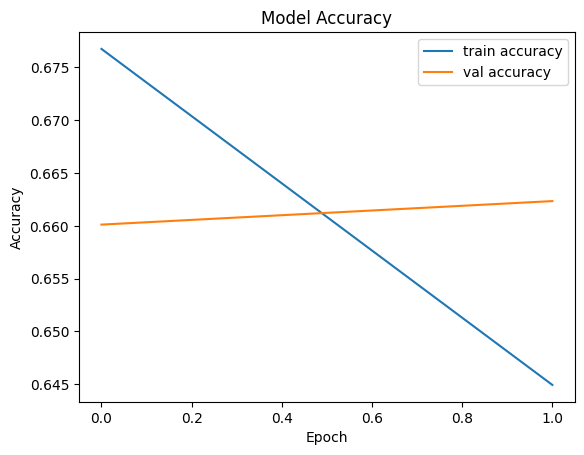

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

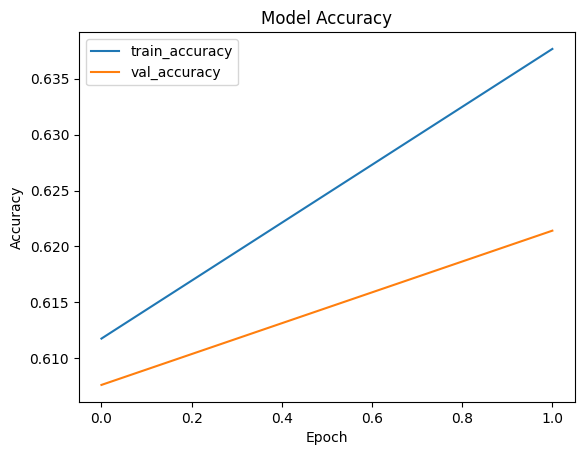

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and testing

In [32]:
test_dataset = test_dataset.batch(1)

In [33]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 26s 5ms/step - loss: 0.6589 - accuracy: 0.6257 - tp: 1158.0000 - tn: 567.0000 - fn: 207.0000 - fp: 825.0000 - precision: 0.5840 - recall: 0.8484 - auc: 0.6657


[0.6589232683181763,
 0.6256800889968872,
 1158.0,
 567.0,
 207.0,
 825.0,
 0.5839636921882629,
 0.8483516573905945,
 0.6657170057296753]

In [34]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

In [35]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'U'

1/1 [==============================] - 0s 18ms/step


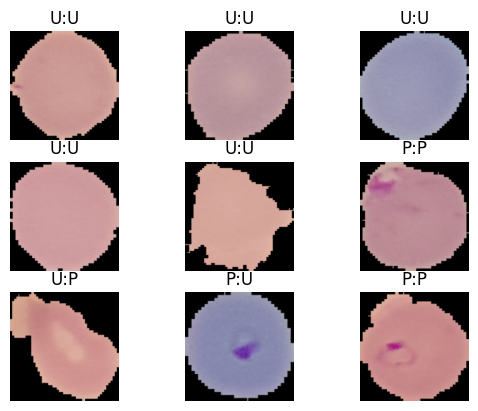

In [36]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')